In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4380191082579725540
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7219843676478563006
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16908744160037381979
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8003360834459398563
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_global_

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"],
                                                   cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [20]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"

In [21]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [22]:
y_imp = Vmag_df.iloc[:, :].values

In [23]:
y = y_imp.reshape((133, 16, n_grid, n_grid))

In [24]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [25]:
geometry2 = np.zeros((133*16,1))
geometry2 = geometry2.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    for j in range(0,16):
        geometry2[16*index_[0]+j,:] = np.asarray(i)

In [27]:
geometry = geometry.reshape((133, 16, 1))

In [29]:
geometry2 = geometry2.reshape((133, 16, 1))

In [30]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, geo_train2, geo_test2, y_train, y_test = train_test_split(
    image, aa, geometry, geometry2, y, test_size=0.3, random_state=1)

In [31]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
geo_train2 = geo_train2.reshape((geo_train2.shape[0]*geo_train2.shape[1], geo_train2.shape[2]))
geo_test2 = geo_test2.reshape((geo_test2.shape[0]*geo_test2.shape[1], geo_test2.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [32]:
with mirrored_strategy.scope():
    input_image = tf.keras.Input(shape=(input_size, input_size, 1))

    x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                    activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                    name='Conv2DLayer1')(input_image)
    x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

    x_ = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1), strides = (2, 2),
                                         padding='same', activation='relu')(x_)
    x_conv = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides, strides),
                                    activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                    name='Conv2DLayer2')(x_)
    reshape1 = tf.keras.layers.Flatten()(x_conv)
    x_ = tf.keras.layers.Dense(units=n_grid*n_grid, activation=None, name='outputLayer',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)

    output_image = tf.keras.layers.Reshape((n_grid, n_grid, 1))(x_)
    # AeroCNN-II based
    model = tf.keras.Model(input_image, output_image)

In [33]:
with mirrored_strategy.scope():
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 50)      1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 50)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 50)     62550     
 nspose)                                                         
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 100, 100, 1)       1251      
                                                                 
 flatten (Flatten)           (None, 10000)             0     

In [34]:
with mirrored_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [35]:
with mirrored_strategy.scope():
    start = datetime.datetime.now()
    history = model.fit(x_train, y_train, epochs=5000, shuffle=True,
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30))
    end = datetime.datetime.now()

Epoch 1/5000
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
47/47 [==============================] - 17s 130ms/step - loss: 2.7442 - rmse: 1.6566
Epoch 2/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.1485 - rmse: 0.3853
Epoch 3/5000
47/47 [==============================] - 6s 129ms/step - loss: 0.1447 - rmse: 0.3804
Epoch 4/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.1199 - rmse: 0.3463
Epoch 5/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0766 - rmse: 0.2768
Epoch 6/5000
47/47 [=============

47/47 [==============================] - 6s 127ms/step - loss: 0.0327 - rmse: 0.1807
Epoch 80/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0328 - rmse: 0.1810
Epoch 81/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0331 - rmse: 0.1818
Epoch 82/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0335 - rmse: 0.1830
Epoch 83/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0327 - rmse: 0.1808
Epoch 84/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0326 - rmse: 0.1806
Epoch 85/5000
47/47 [==============================] - 6s 129ms/step - loss: 0.0314 - rmse: 0.1771
Epoch 86/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0314 - rmse: 0.1772
Epoch 87/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0318 - rmse: 0.1783
Epoch 88/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0311 - rmse: 0.1764
Epoch 89/5000
47/47 [===

47/47 [==============================] - 6s 129ms/step - loss: 0.0249 - rmse: 0.1578
Epoch 162/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0251 - rmse: 0.1582
Epoch 163/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0249 - rmse: 0.1576
Epoch 164/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0251 - rmse: 0.1584
Epoch 165/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0247 - rmse: 0.1570
Epoch 166/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0249 - rmse: 0.1578
Epoch 167/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0249 - rmse: 0.1576
Epoch 168/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0246 - rmse: 0.1569
Epoch 169/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0247 - rmse: 0.1570
Epoch 170/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0243 - rmse: 0.1557
Epoch 171/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0217 - rmse: 0.1471
Epoch 244/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0213 - rmse: 0.1460
Epoch 245/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0220 - rmse: 0.1481
Epoch 246/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0223 - rmse: 0.1491
Epoch 247/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0218 - rmse: 0.1475
Epoch 248/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0213 - rmse: 0.1458
Epoch 249/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0217 - rmse: 0.1473
Epoch 250/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0213 - rmse: 0.1459
Epoch 251/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0210 - rmse: 0.1447
Epoch 252/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0212 - rmse: 0.1456
Epoch 253/5000


47/47 [==============================] - 6s 128ms/step - loss: 0.0184 - rmse: 0.1356
Epoch 326/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0188 - rmse: 0.1370
Epoch 327/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0188 - rmse: 0.1371
Epoch 328/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0185 - rmse: 0.1361
Epoch 329/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0187 - rmse: 0.1367
Epoch 330/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0189 - rmse: 0.1374
Epoch 331/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0182 - rmse: 0.1347
Epoch 332/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0187 - rmse: 0.1368
Epoch 333/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0183 - rmse: 0.1352
Epoch 334/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0185 - rmse: 0.1360
Epoch 335/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0160 - rmse: 0.1263
Epoch 408/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0161 - rmse: 0.1268
Epoch 409/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0162 - rmse: 0.1270
Epoch 410/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0167 - rmse: 0.1289
Epoch 411/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0157 - rmse: 0.1252
Epoch 412/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0159 - rmse: 0.1259
Epoch 413/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0160 - rmse: 0.1263
Epoch 414/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0155 - rmse: 0.1243
Epoch 415/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0157 - rmse: 0.1252
Epoch 416/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0158 - rmse: 0.1255
Epoch 417/5000


47/47 [==============================] - 6s 127ms/step - loss: 0.0136 - rmse: 0.1163
Epoch 490/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 491/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0134 - rmse: 0.1155
Epoch 492/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 493/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0141 - rmse: 0.1187
Epoch 494/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0136 - rmse: 0.1163
Epoch 495/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 496/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 497/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 498/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0163 - rmse: 0.1276
Epoch 499/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0118 - rmse: 0.1083
Epoch 572/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0119 - rmse: 0.1090
Epoch 573/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0117 - rmse: 0.1078
Epoch 574/5000
47/47 [==============================] - 6s 125ms/step - loss: 0.0116 - rmse: 0.1073
Epoch 575/5000
47/47 [==============================] - 6s 125ms/step - loss: 0.0115 - rmse: 0.1070
Epoch 576/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0112 - rmse: 0.1058
Epoch 577/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0114 - rmse: 0.1068
Epoch 578/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0116 - rmse: 0.1077
Epoch 579/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0117 - rmse: 0.1079
Epoch 580/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0116 - rmse: 0.1075
Epoch 581/5000


47/47 [==============================] - 6s 127ms/step - loss: 0.0103 - rmse: 0.1012
Epoch 654/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0100 - rmse: 0.0997
Epoch 655/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0102 - rmse: 0.1008
Epoch 656/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0101 - rmse: 0.1003
Epoch 657/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0108 - rmse: 0.1036
Epoch 658/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0106 - rmse: 0.1030
Epoch 659/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0103 - rmse: 0.1011
Epoch 660/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0104 - rmse: 0.1015
Epoch 661/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0101 - rmse: 0.1005
Epoch 662/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0103 - rmse: 0.1012
Epoch 663/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0090 - rmse: 0.0946
Epoch 736/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0092 - rmse: 0.0955
Epoch 737/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0093 - rmse: 0.0961
Epoch 738/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0092 - rmse: 0.0955
Epoch 739/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0092 - rmse: 0.0956
Epoch 740/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0091 - rmse: 0.0951
Epoch 741/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0093 - rmse: 0.0960
Epoch 742/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0091 - rmse: 0.0951
Epoch 743/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0092 - rmse: 0.0955
Epoch 744/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0091 - rmse: 0.0950
Epoch 745/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0082 - rmse: 0.0903
Epoch 818/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0081 - rmse: 0.0898
Epoch 819/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0081 - rmse: 0.0895
Epoch 820/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0085 - rmse: 0.0919
Epoch 821/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0082 - rmse: 0.0902
Epoch 822/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0082 - rmse: 0.0901
Epoch 823/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0082 - rmse: 0.0904
Epoch 824/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0084 - rmse: 0.0911
Epoch 825/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0081 - rmse: 0.0895
Epoch 826/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0088 - rmse: 0.0935
Epoch 827/5000


47/47 [==============================] - 6s 126ms/step - loss: 0.0072 - rmse: 0.0846
Epoch 900/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0074 - rmse: 0.0856
Epoch 901/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0077 - rmse: 0.0877
Epoch 902/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0076 - rmse: 0.0868
Epoch 903/5000
47/47 [==============================] - 6s 125ms/step - loss: 0.0075 - rmse: 0.0864
Epoch 904/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0071 - rmse: 0.0838
Epoch 905/5000
47/47 [==============================] - 6s 126ms/step - loss: 0.0076 - rmse: 0.0870
Epoch 906/5000
47/47 [==============================] - 6s 127ms/step - loss: 0.0073 - rmse: 0.0853
Epoch 907/5000
47/47 [==============================] - 6s 125ms/step - loss: 0.0073 - rmse: 0.0849
Epoch 908/5000
47/47 [==============================] - 6s 128ms/step - loss: 0.0079 - rmse: 0.0885
Epoch 909/5000


In [36]:
time = end - start
print("Training time:", time)

Training time: 1:34:00.536893


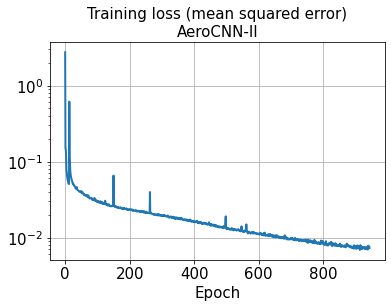

In [37]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

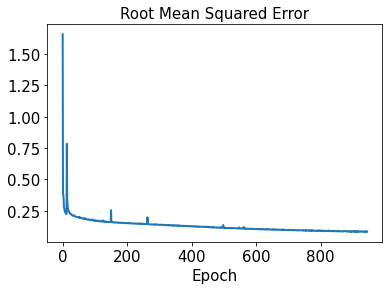

In [38]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

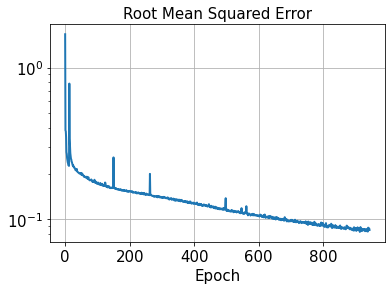

In [39]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [40]:
with mirrored_strategy.scope():
    test_results = model.evaluate(x_train)
    decoded_train = model.predict(x_train)
    decoded_test = model.predict(x_test)

20/20 [==============================] - 0s 17ms/step


In [41]:
test_results2 = model.evaluate(x_test)

20/20 [==============================] - 0s 7ms/step - loss: 5.3662e-05 - rmse: 0.0000e+00


In [42]:
y_train.shape

(1488, 101, 101)

In [43]:
y_train.shape[0]

1488

In [44]:
type(decoded_train.shape[3])

int

In [45]:
type(decoded_train)

numpy.ndarray

In [46]:
type(n_grid)

int

In [47]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [48]:
decoded_train.shape

(1488, 101, 101)

In [49]:
y_train.shape[0]

1488

In [50]:
error_train_abs = np.abs(decoded_train - y_train)

In [51]:
error_test_abs = np.abs(decoded_test - y_test)

In [52]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [53]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [54]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [55]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [56]:
decoded_train.shape

(1488, 101, 101)

In [57]:
os.chdir("D:\\TrainedModels")

In [58]:
os.chdir("D:\\TrainedModels\\20221007")
model.save('AeroCNN-II_FlowFieldPrediction_50kernel_2by2MaxPooling_1CNNlayer_testSize0.3.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [59]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.016596344648664798


In [60]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.043666710540626125


In [61]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.01485443983081888, 0.009545834412668869, 0.011244575671763641, 0.01014527367364526, 0.009715618106477503, 0.010009795855202988, 0.010547980504137678, 0.011441721326964747, 0.009884696078486596, 0.010638316797542601, 0.01305184500834328, 0.013258136636069437, 0.015982739045915875, 0.01774543698781173, 0.01730126293797216, 0.013451025326506542, 0.008695324213402088, 0.008403784902518058, 0.008383174384940935, 0.007926322007806881, 0.008247085016060932, 0.008916465959246384, 0.00802600427337652, 0.009260660306337761, 0.010349113612996225, 0.009137852128457403, 0.011941456023460586, 0.01584424133077977, 0.014962583317524805, 0.013995585555707228, 0.017340087894887717, 0.016456784013660783, 0.012135249959935519, 0.013428884976005641, 0.010817321999158847, 0.007177929432373311, 0.007650378615916784, 0.007709181247659654, 0.00865956129711257, 0.00892872372734565, 0.009611267977044941, 0.012034630827083862, 0.016394027188155105, 0.012067052822534945, 0.011369828720917964, 0.0252043267944161

In [62]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.009944446734805329, 0.015540723367645492, 0.00985164485166153, 0.009548417453796778, 0.0074438432014929294, 0.007566744868467334, 0.007785387346380173, 0.00896255260064508, 0.01182956081656458, 0.009311409383885097, 0.04356555783270137, 0.012878963865317072, 0.024095114022727057, 0.04049735486630207, 0.06892946951926995, 0.06642629335315124, 0.02086862243604253, 0.017306828512565566, 0.018256841832544144, 0.020389731118600186, 0.017188605430745258, 0.01638489823389166, 0.018387788440207824, 0.01999091769879797, 0.018254742295043296, 0.024468719084147175, 0.02164627354658971, 0.024397150743418868, 0.028295281518685548, 0.03670399062935588, 0.059021775185027485, 0.14184749426460996, 0.018386967833583574, 0.01856326319684996, 0.012063277940974112, 0.010501714650599512, 0.010727845061001889, 0.01111709452021354, 0.01184730028881368, 0.012568592360445776, 0.012406994740027173, 0.013109520377949069, 0.04750785113345619, 0.02289257367869559, 0.05968712191397149, 0.07292094649015912, 0.0347

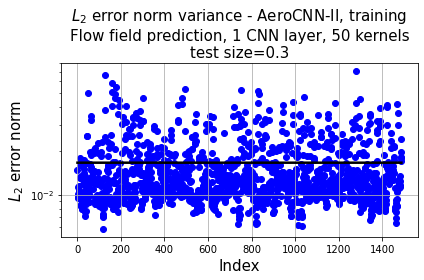

In [63]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, training\nFlow field prediction, 1 CNN layer, 50 kernels\ntest size=0.3', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

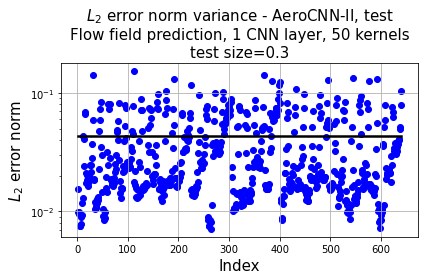

In [64]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test\nFlow field prediction, 1 CNN layer, 50 kernels\ntest size=0.3', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

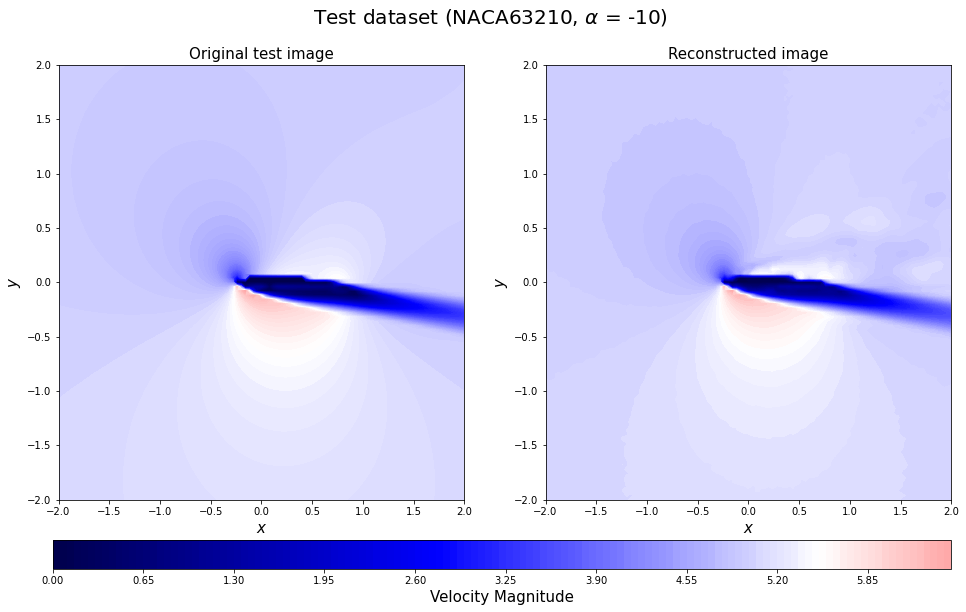

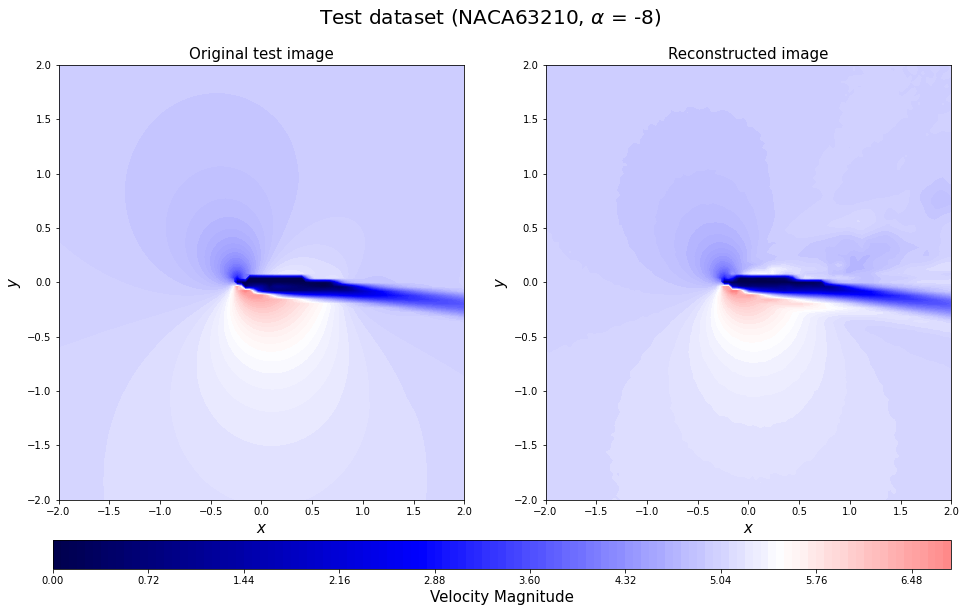

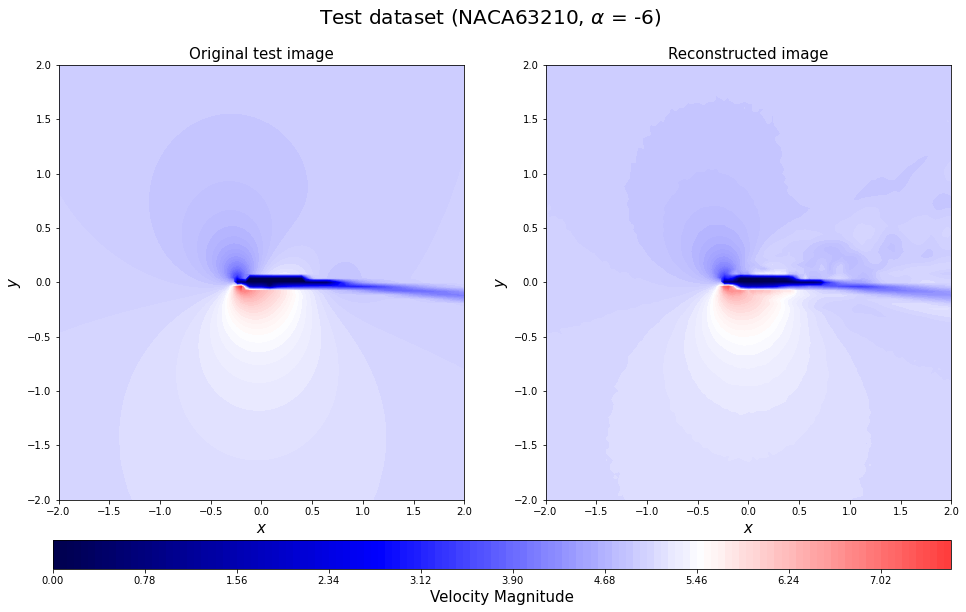

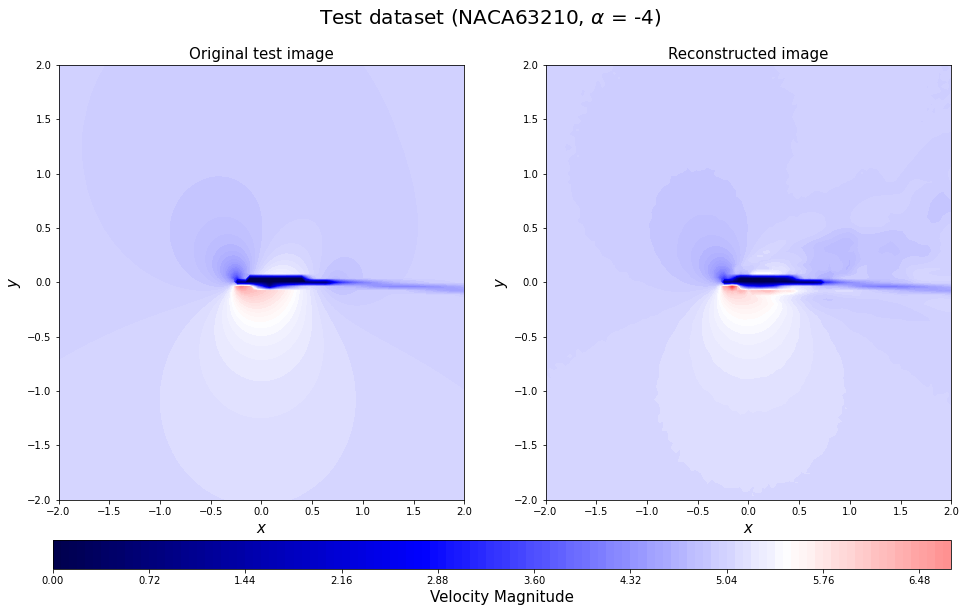

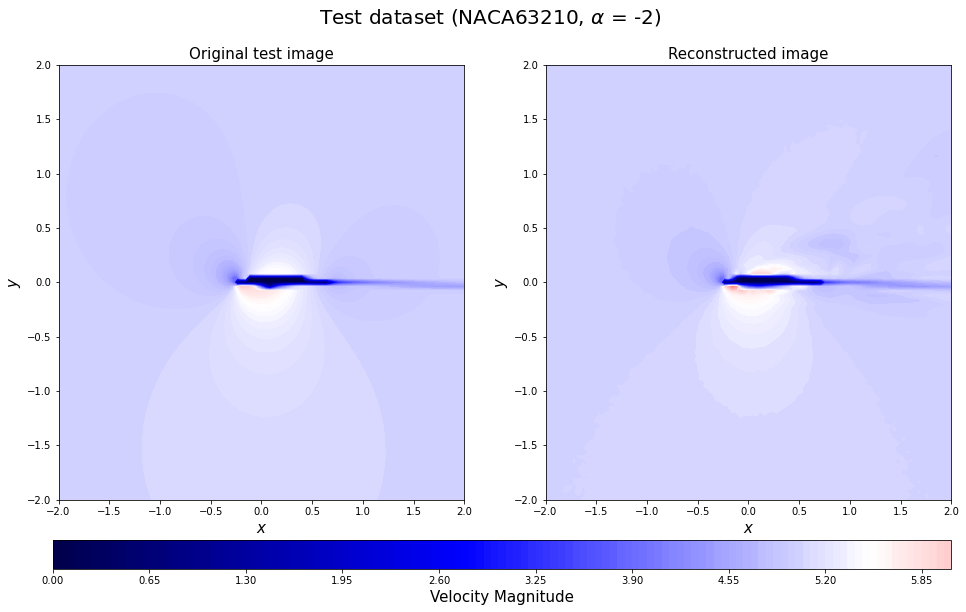

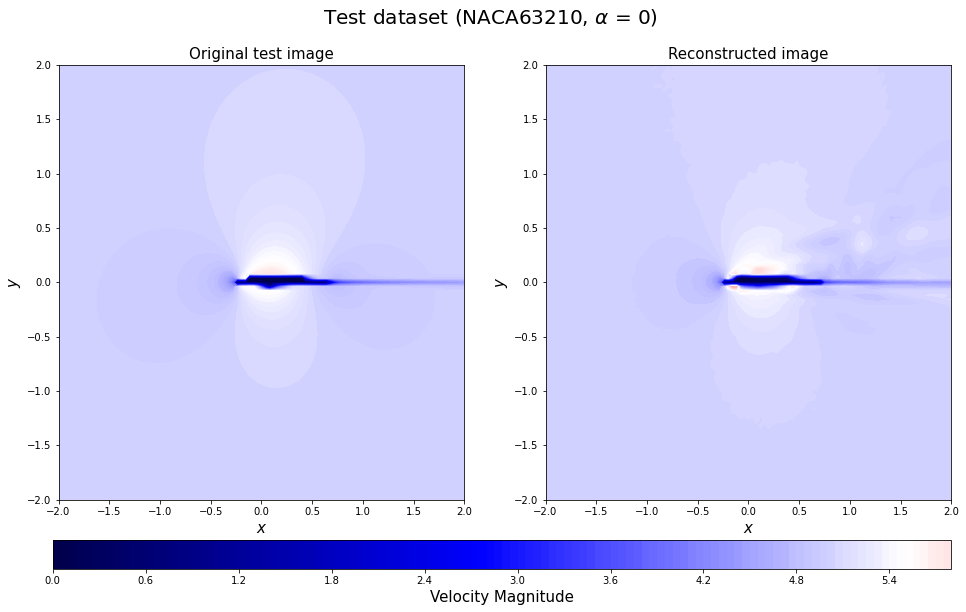

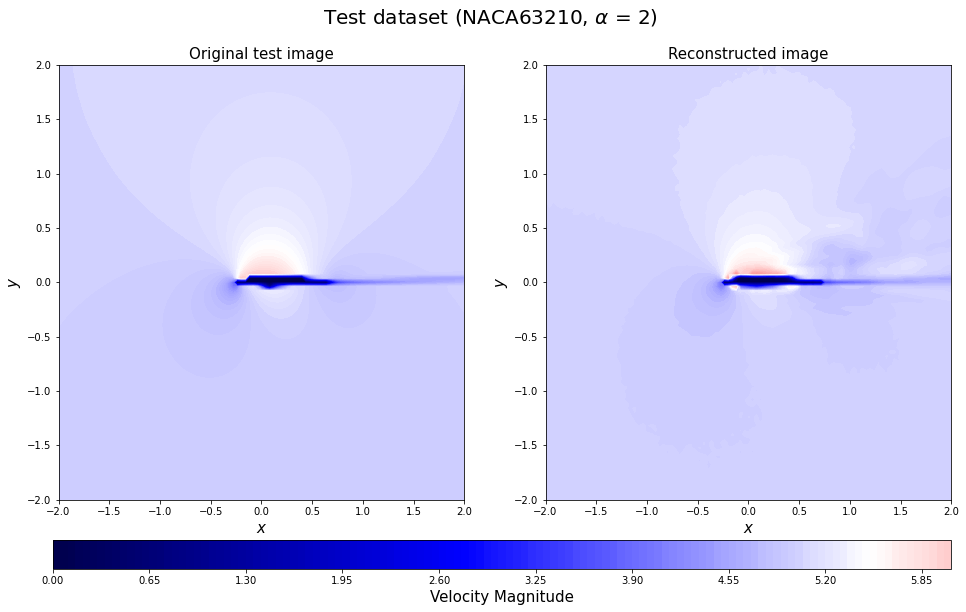

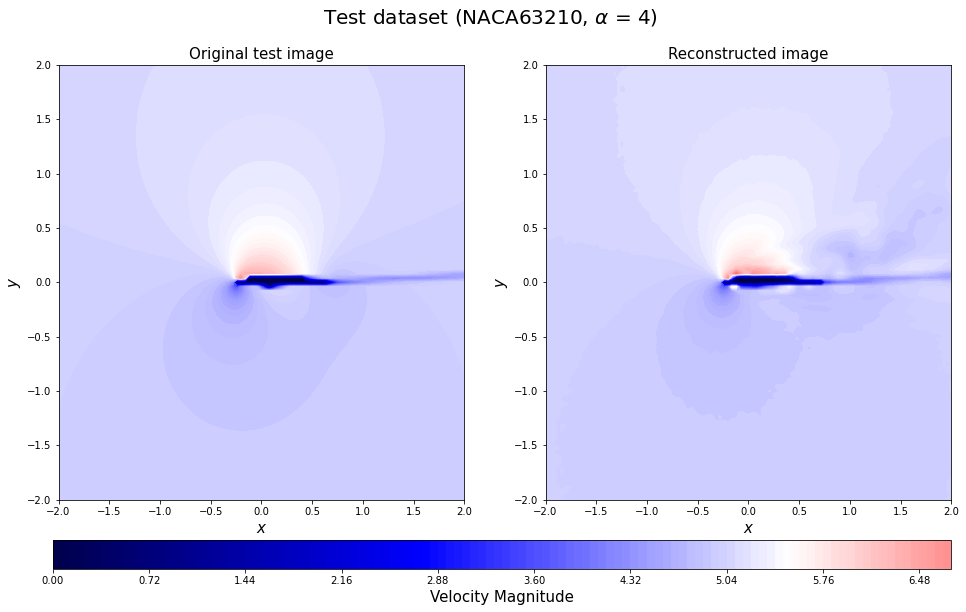

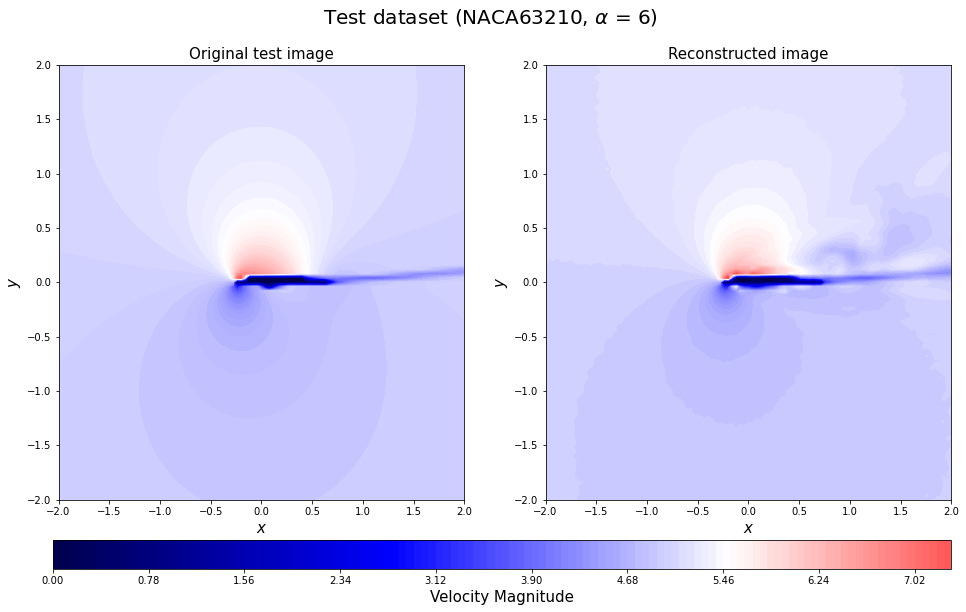

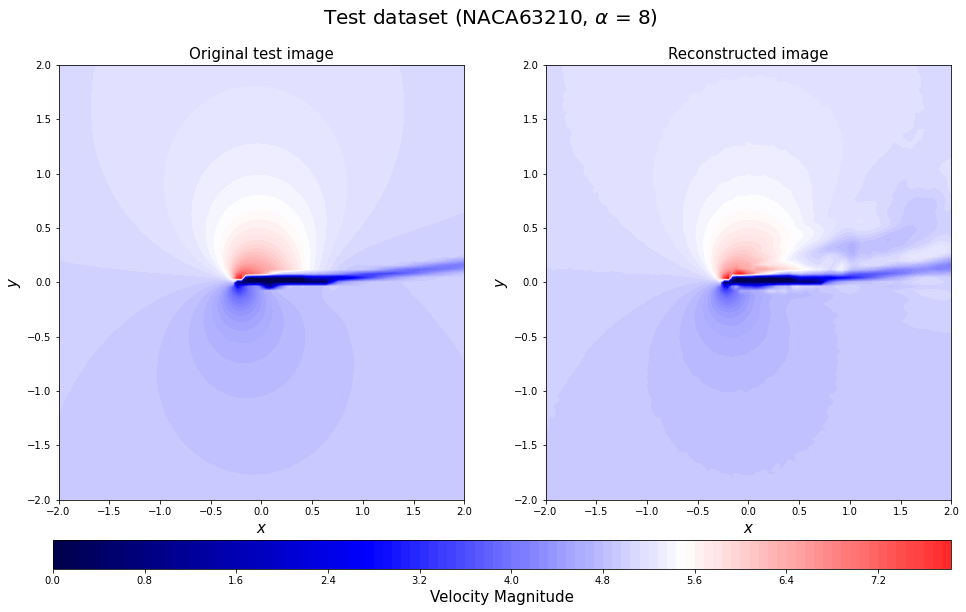

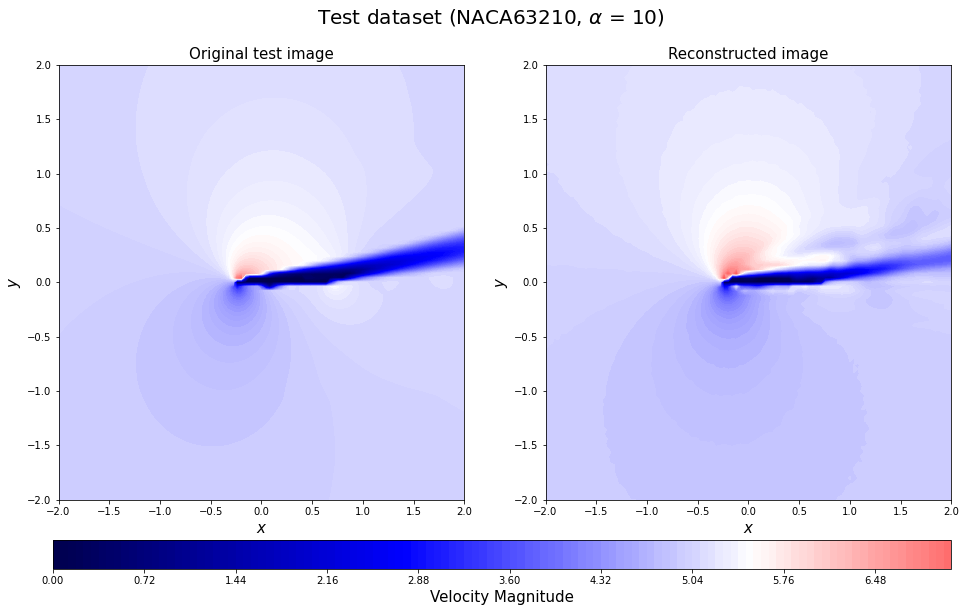

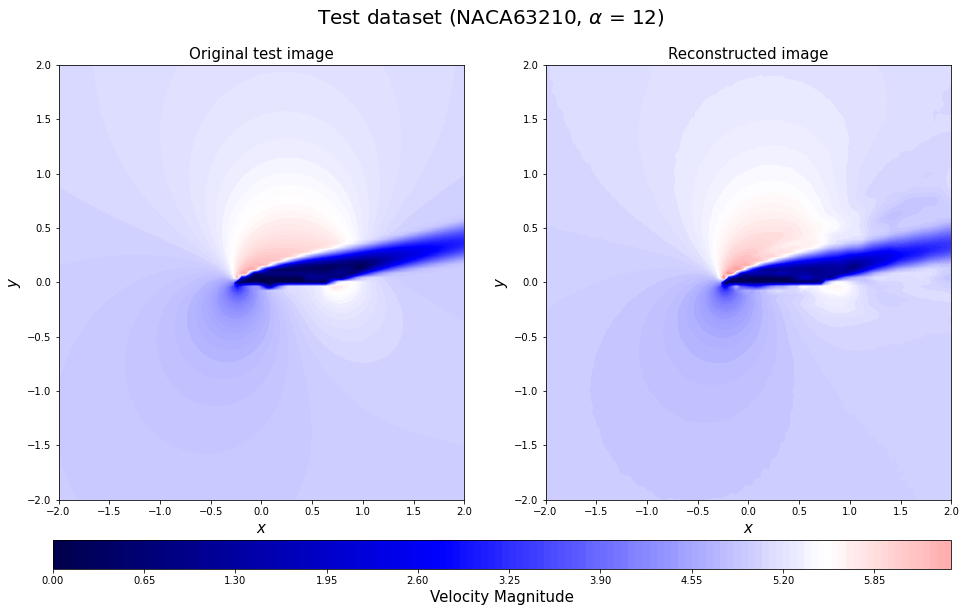

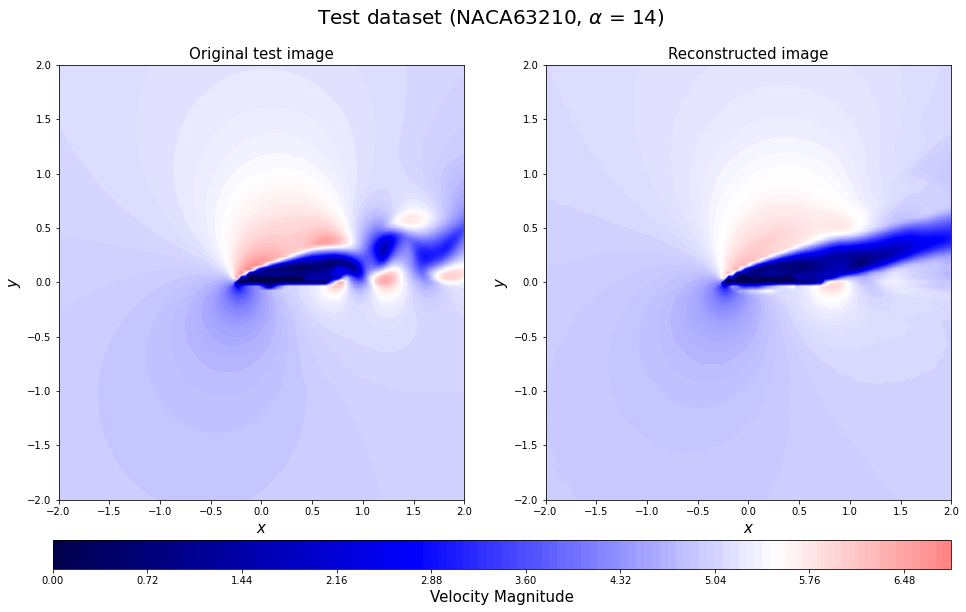

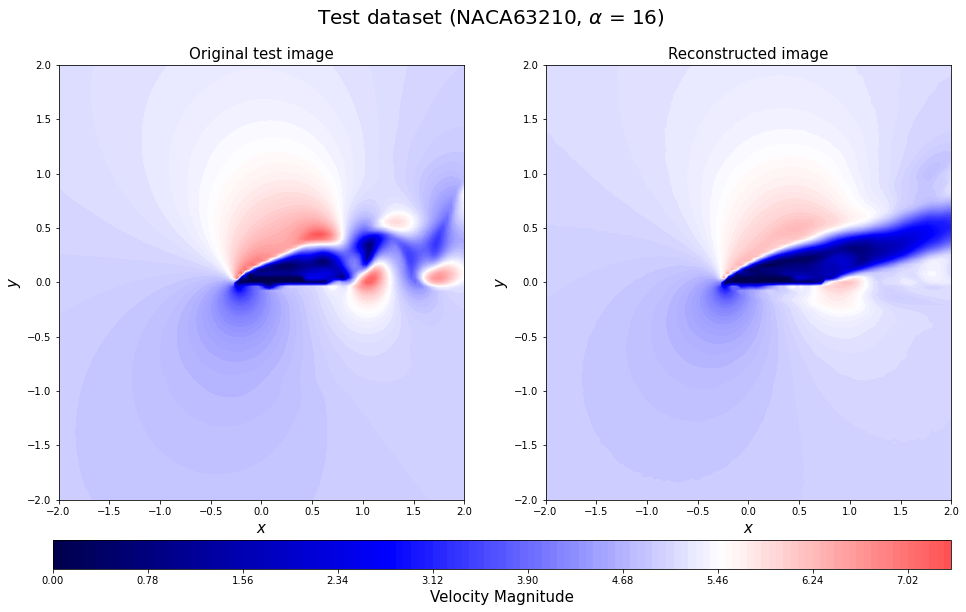

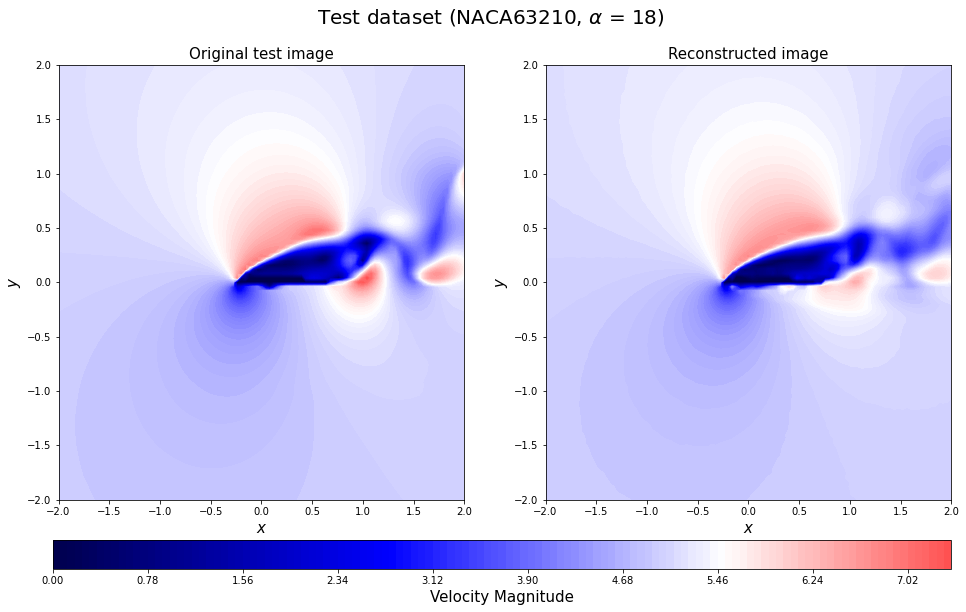

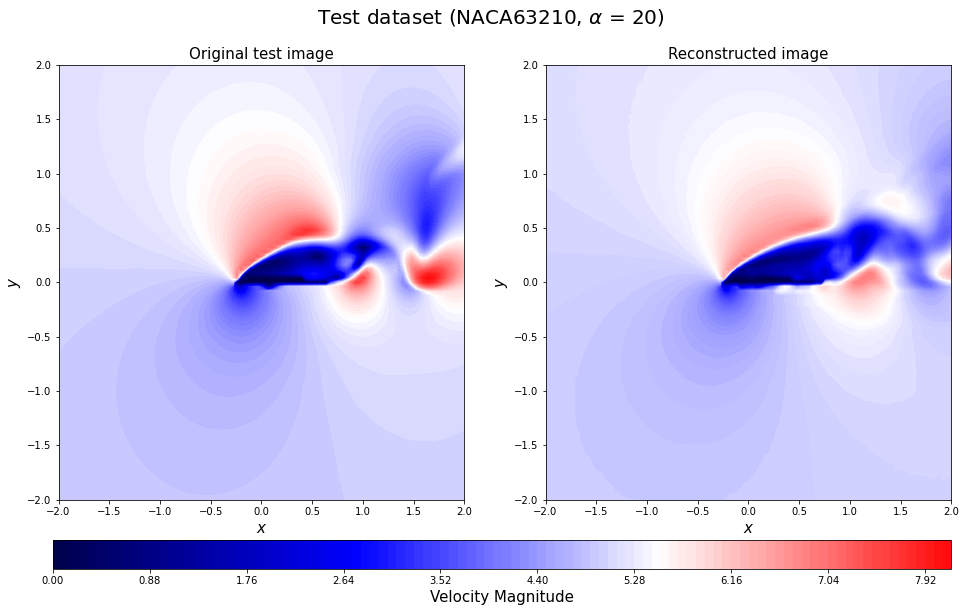

In [65]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test2[2*16+c])[3:-2], aa_test[2*16+c]),fontsize=20)
    plt.show()

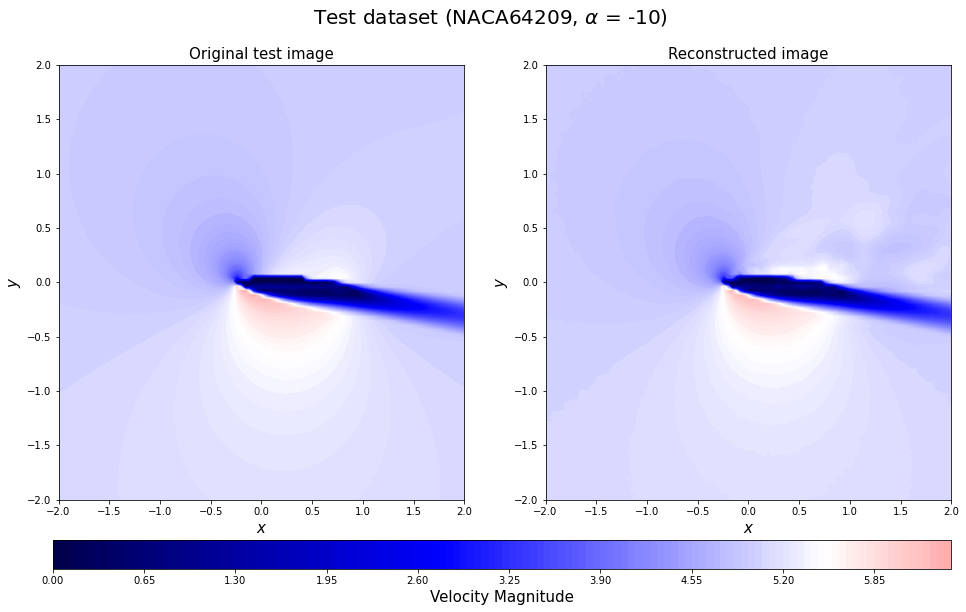

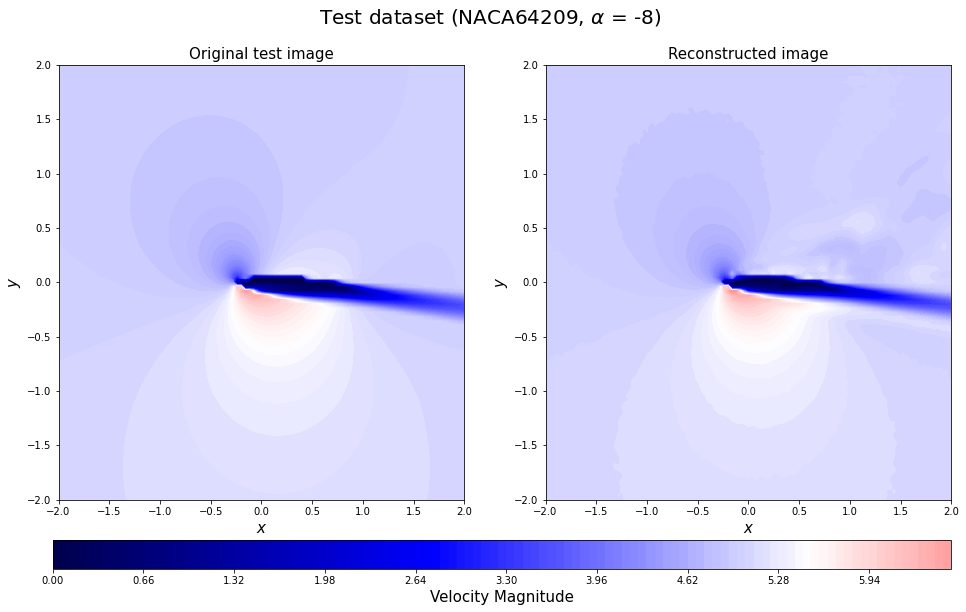

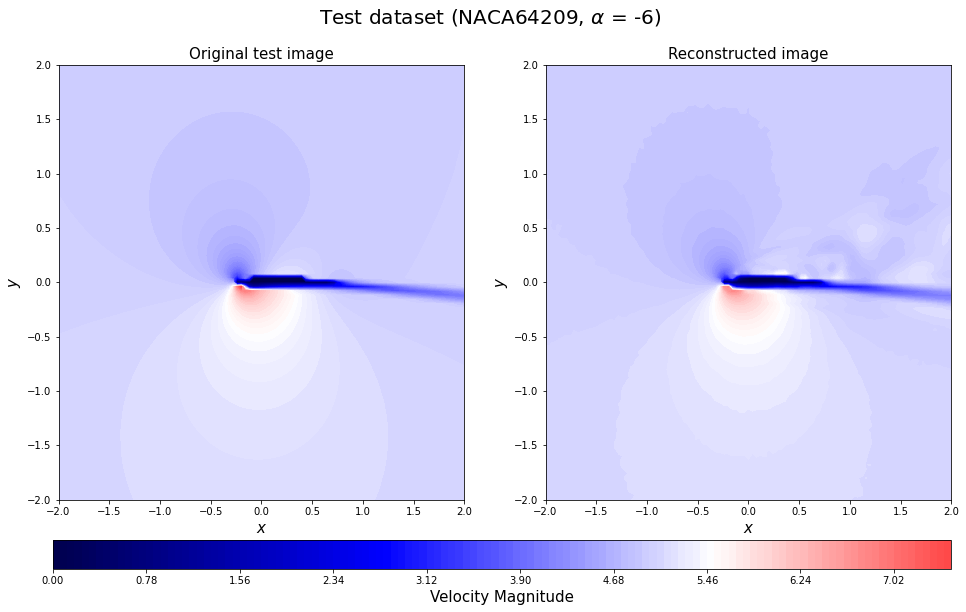

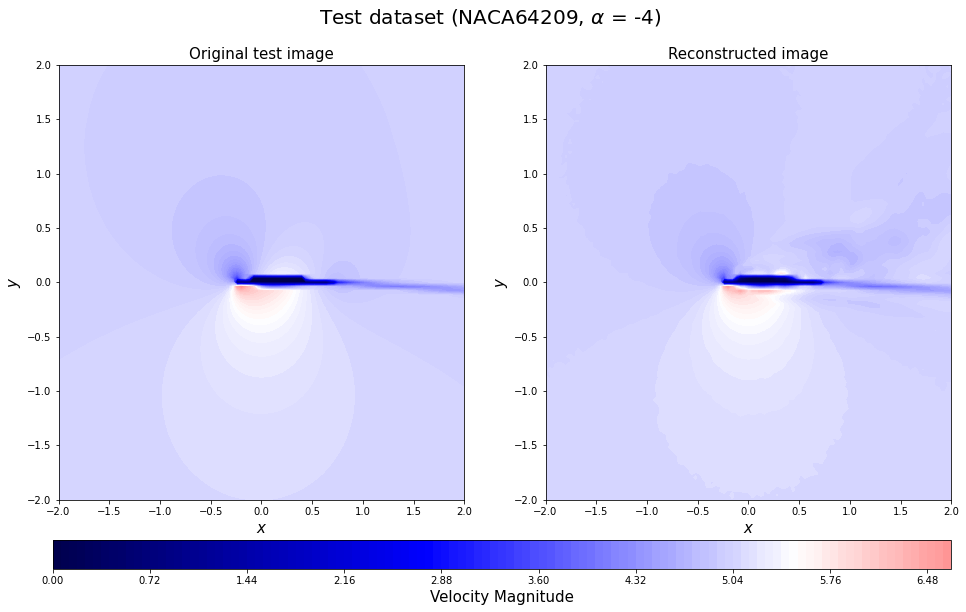

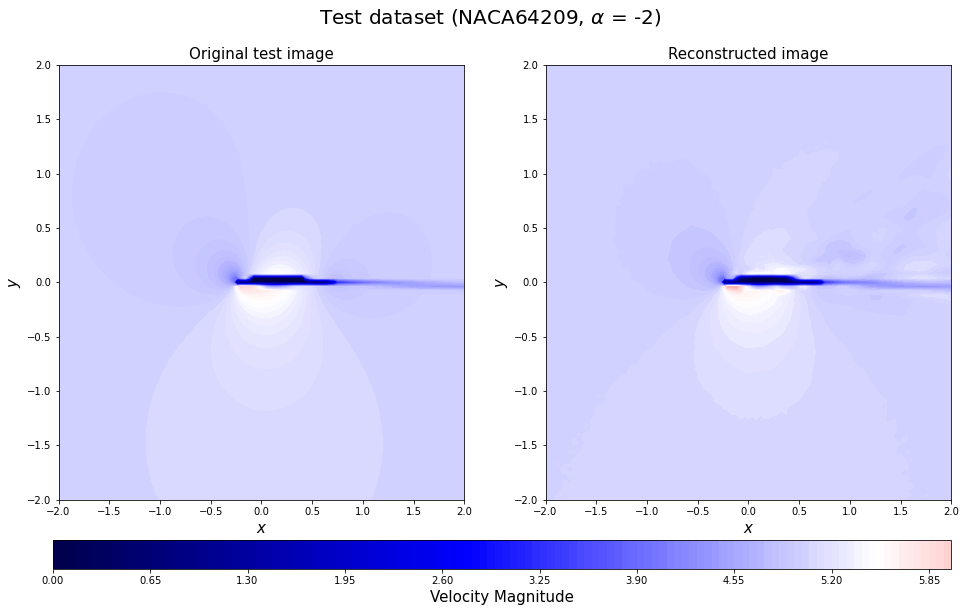

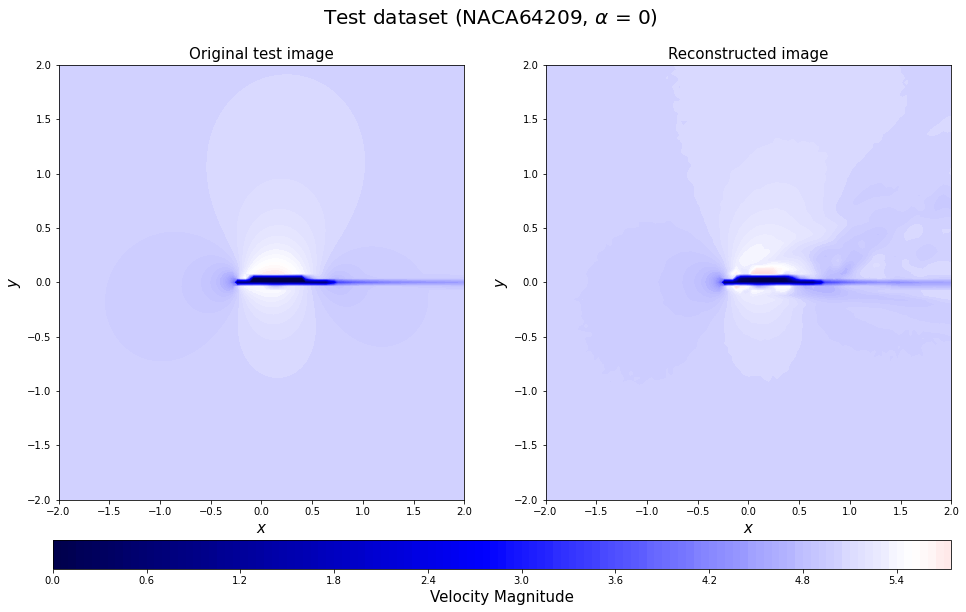

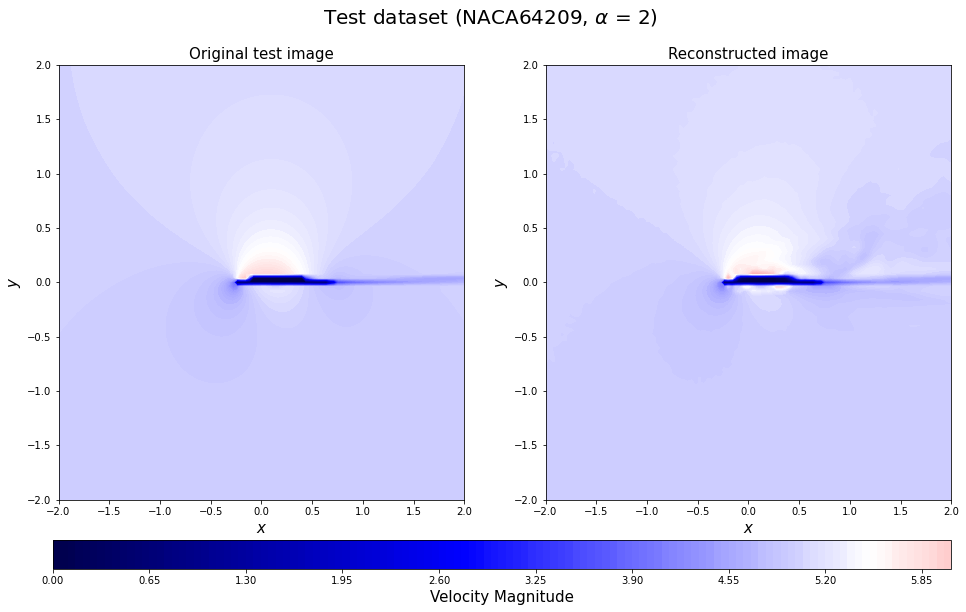

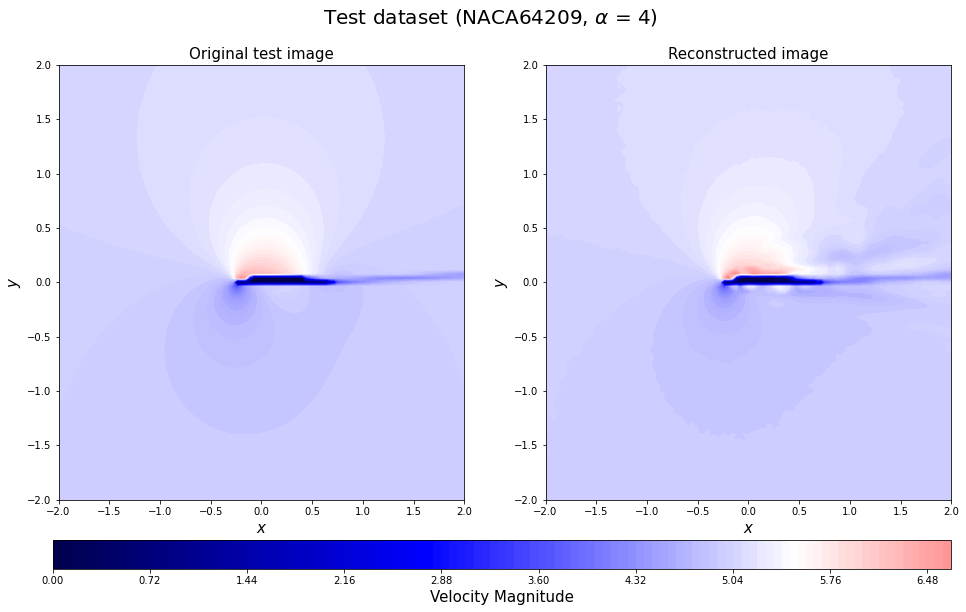

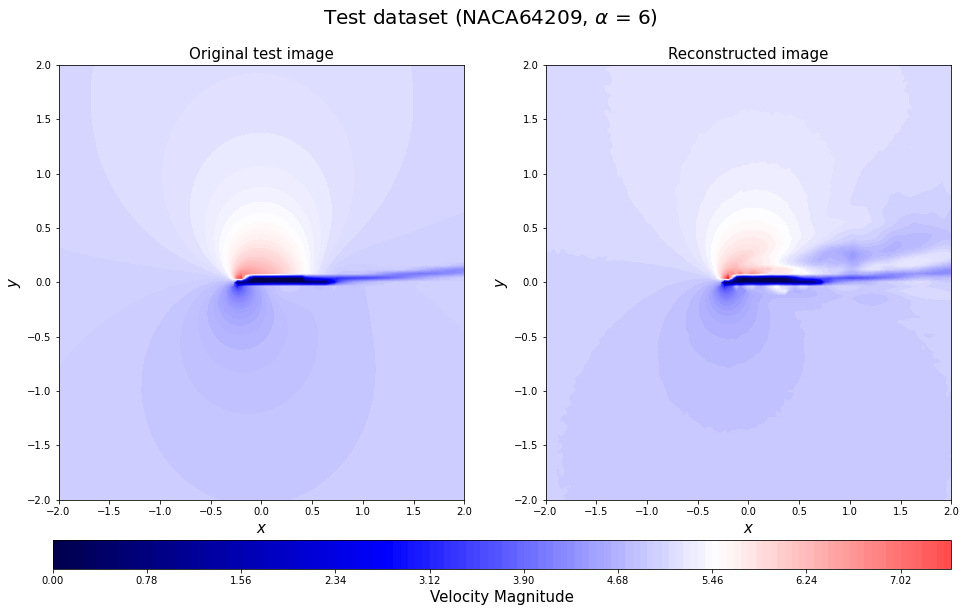

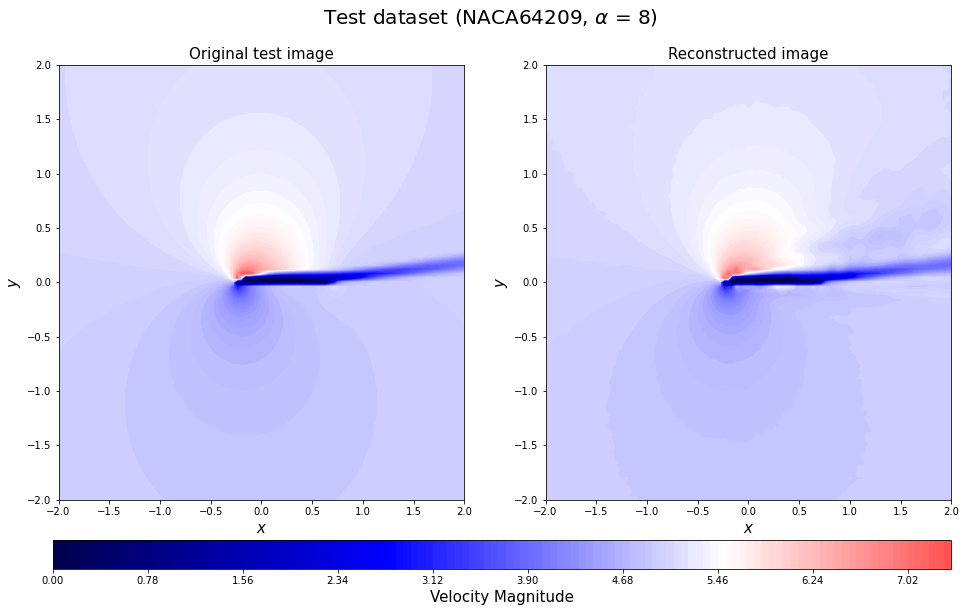

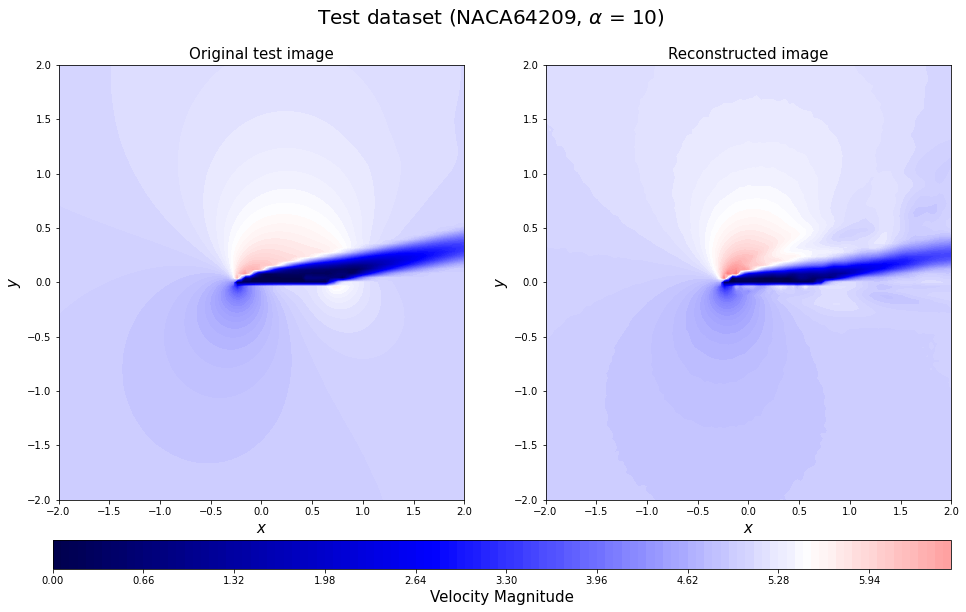

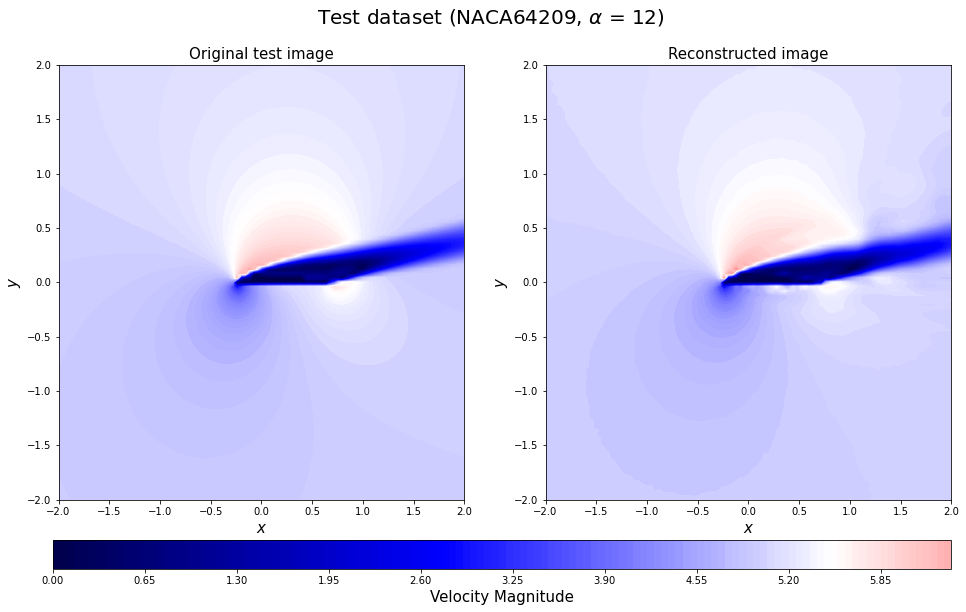

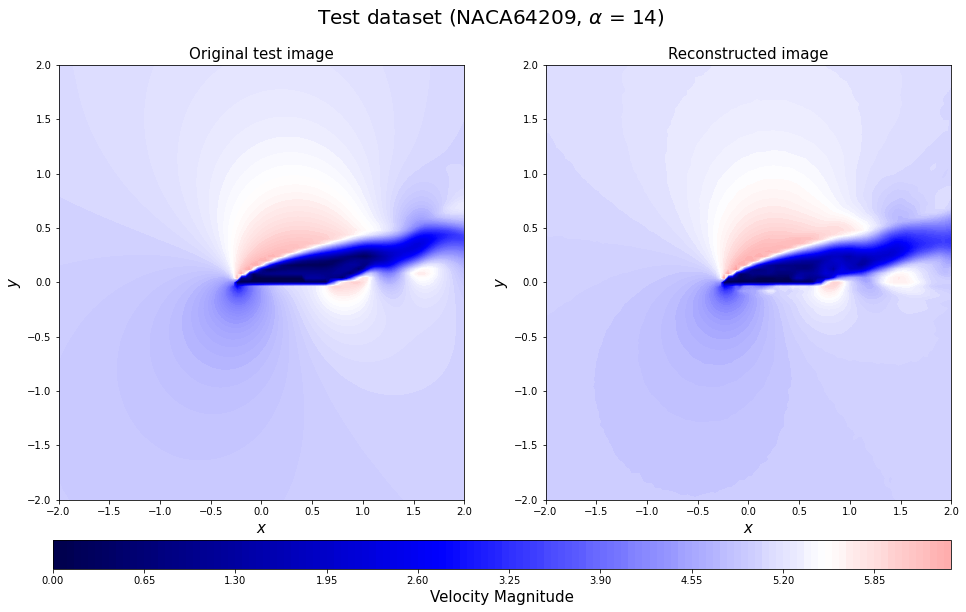

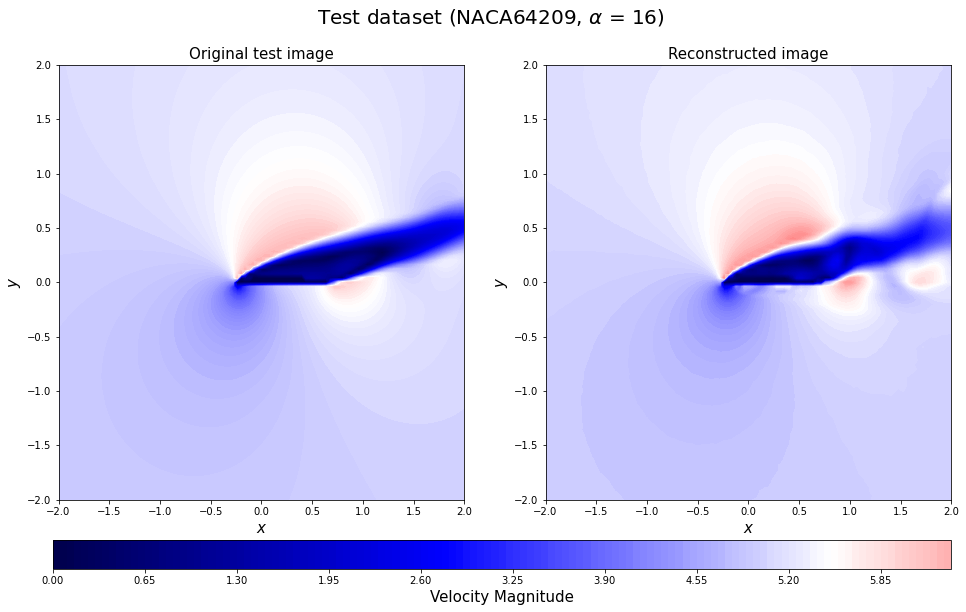

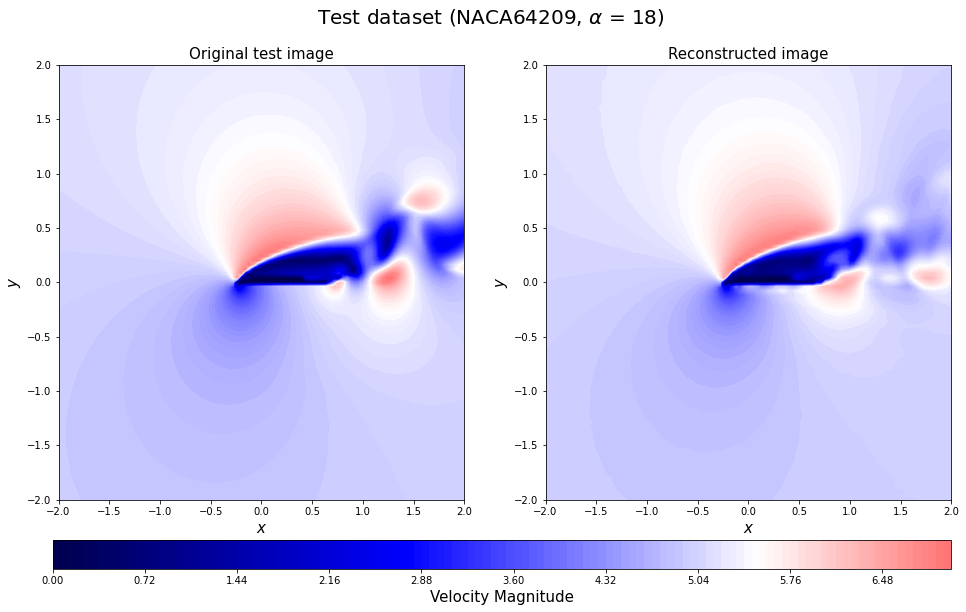

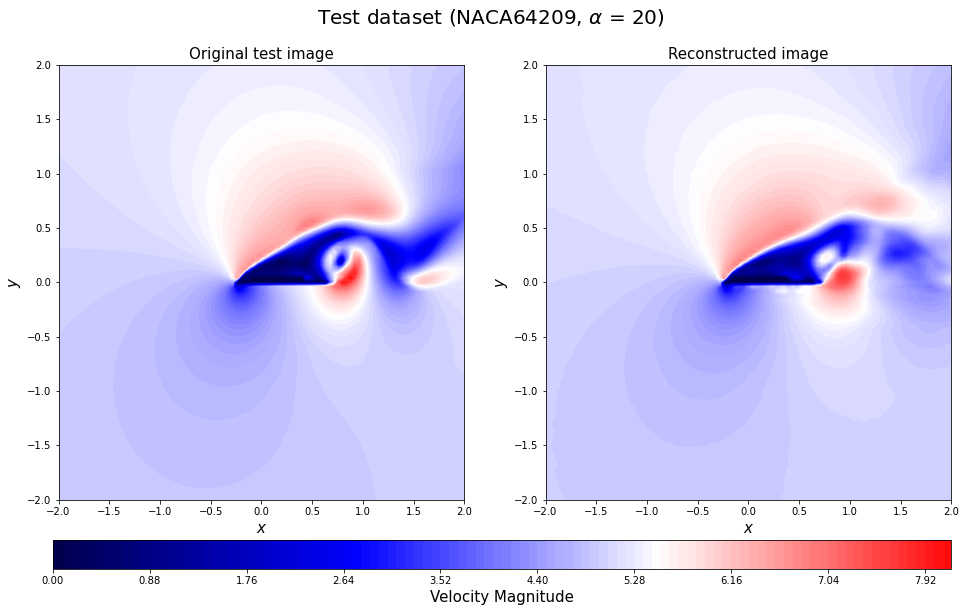

In [66]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test2[c])[3:-2], aa_test[c]),fontsize=20)
    plt.show()

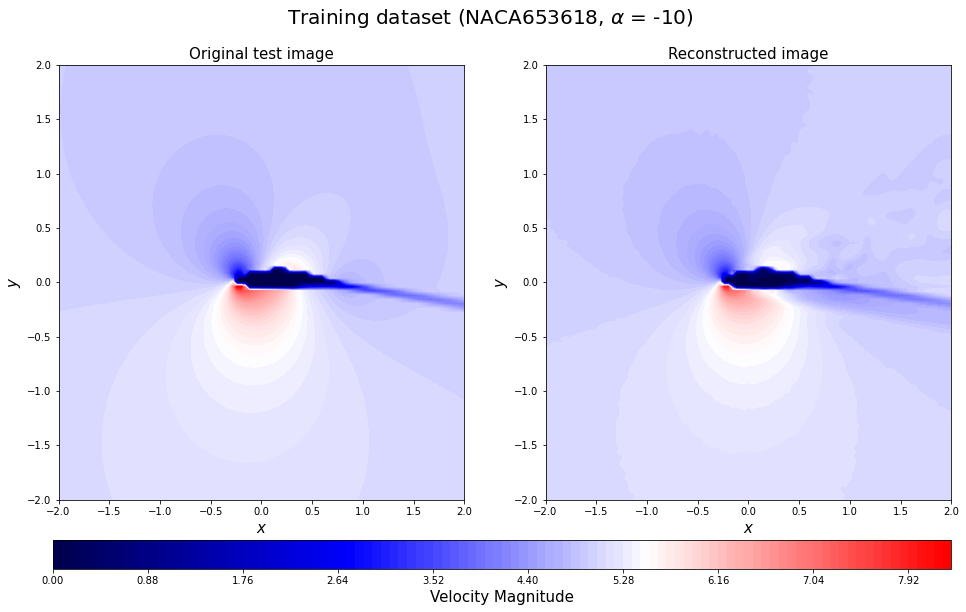

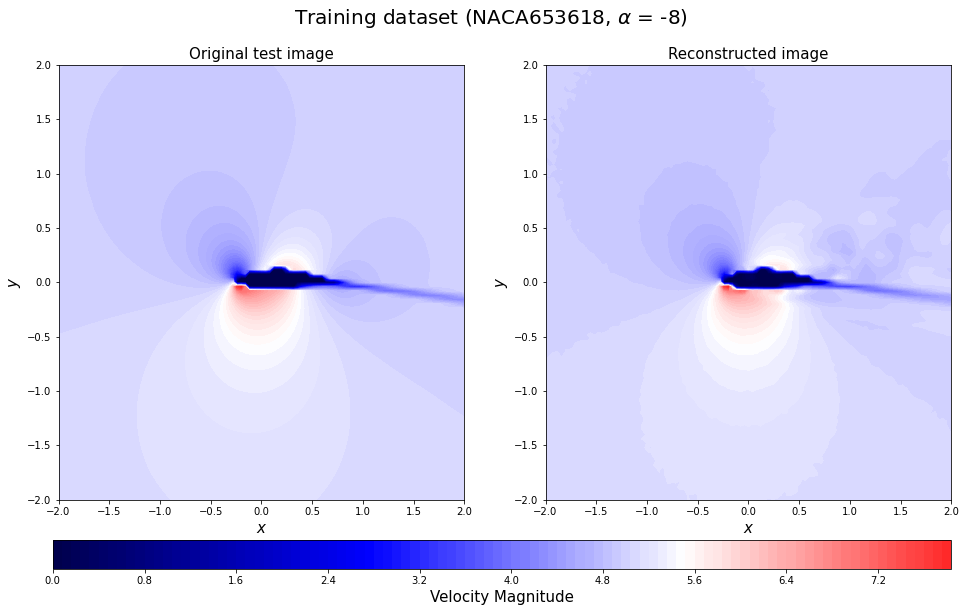

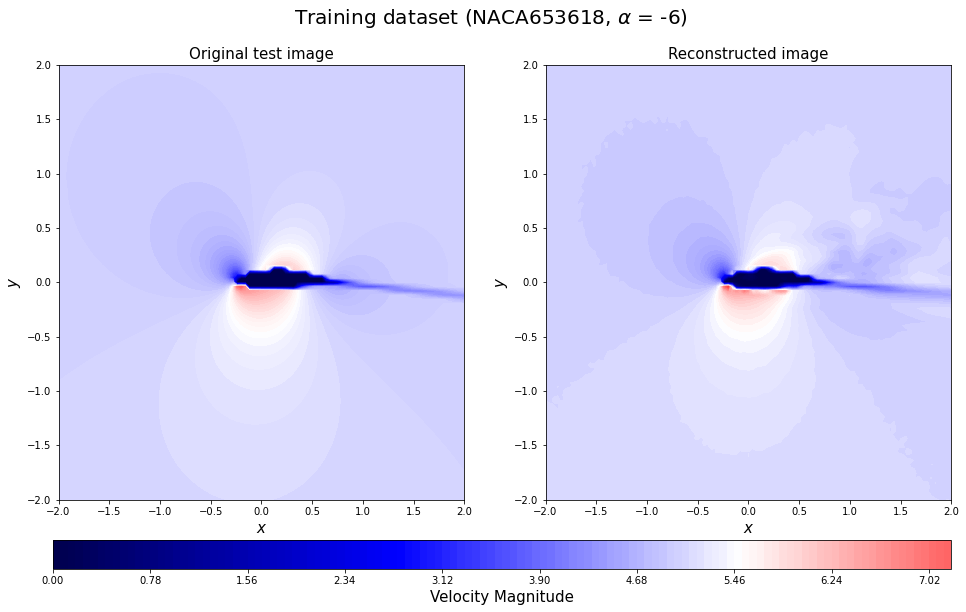

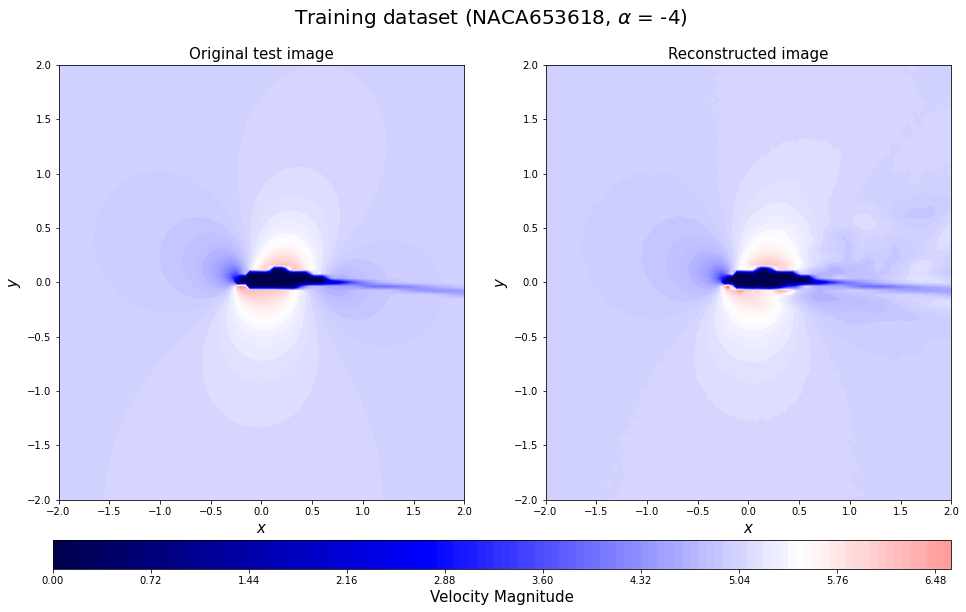

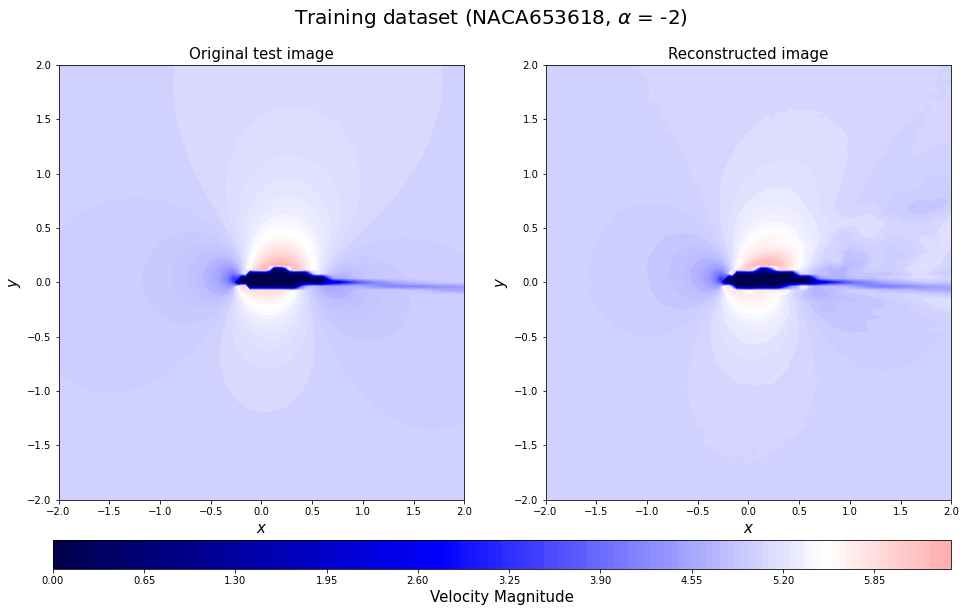

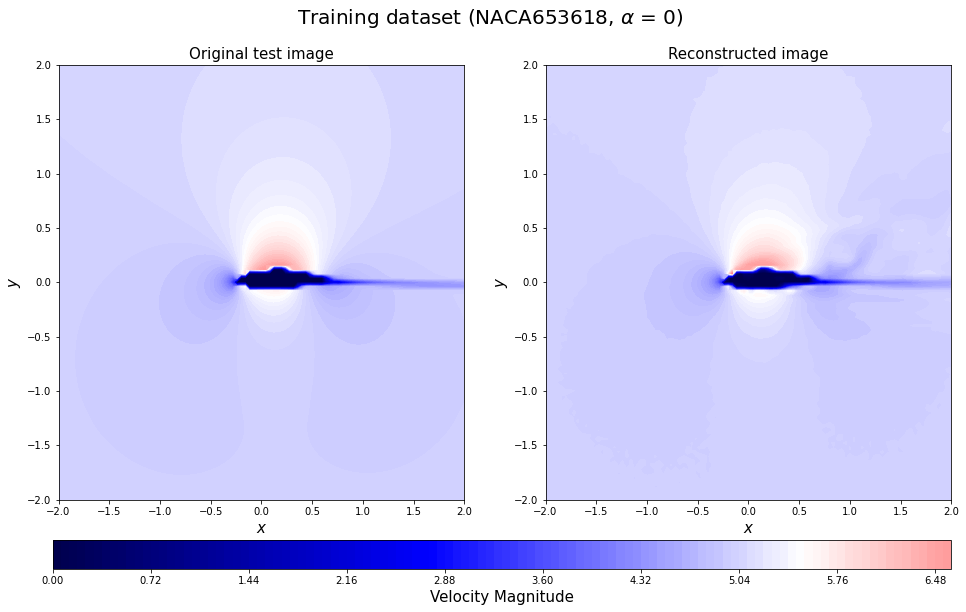

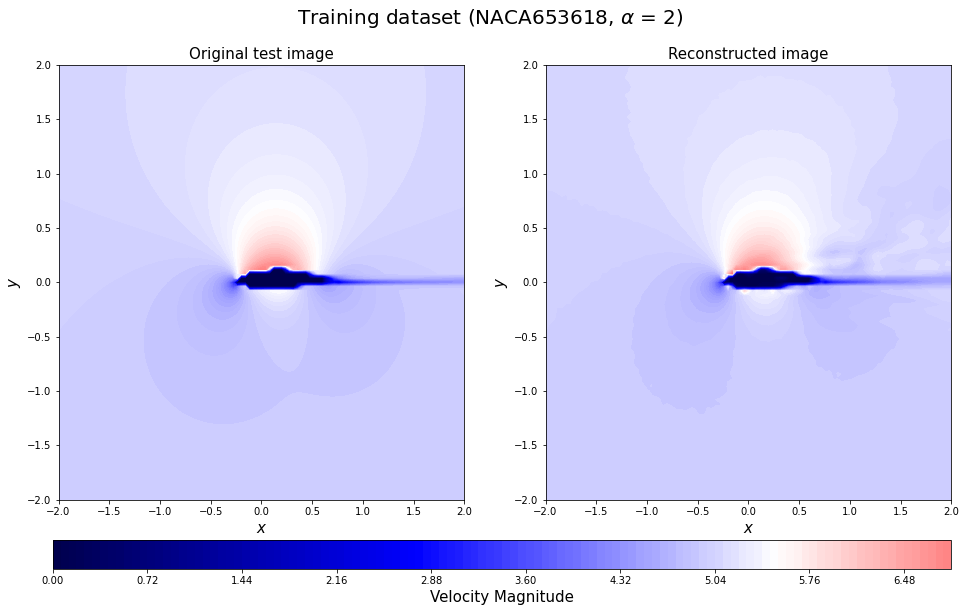

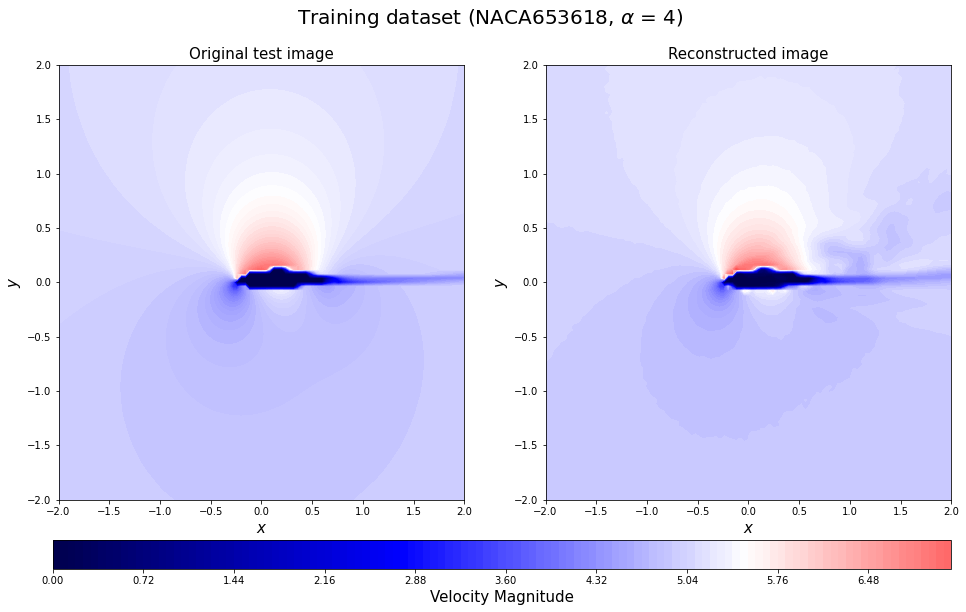

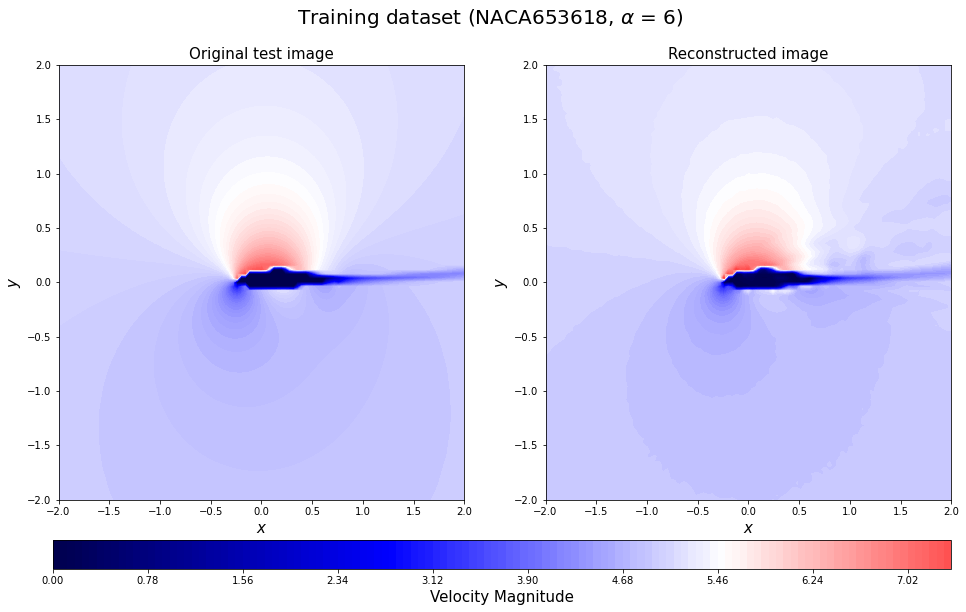

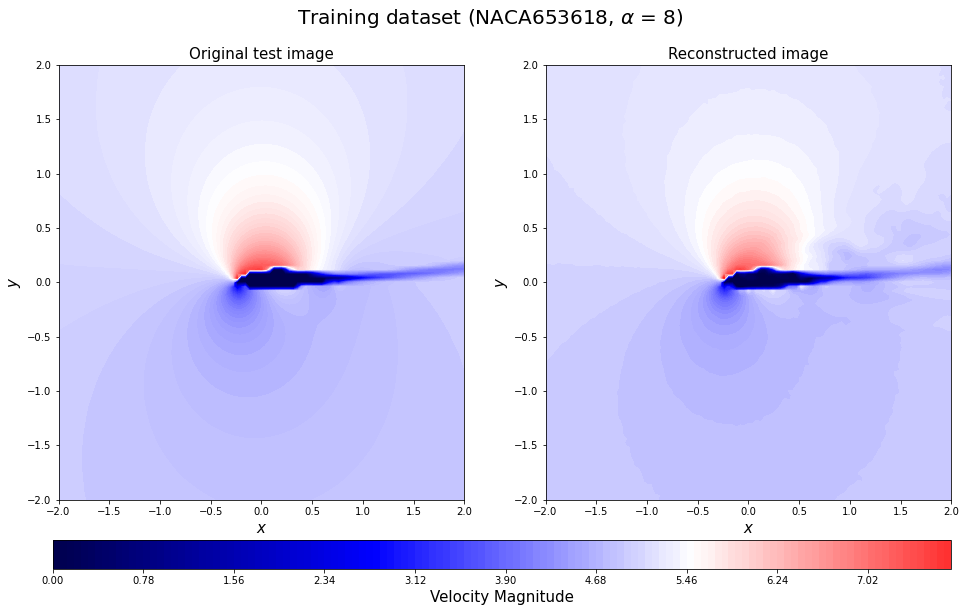

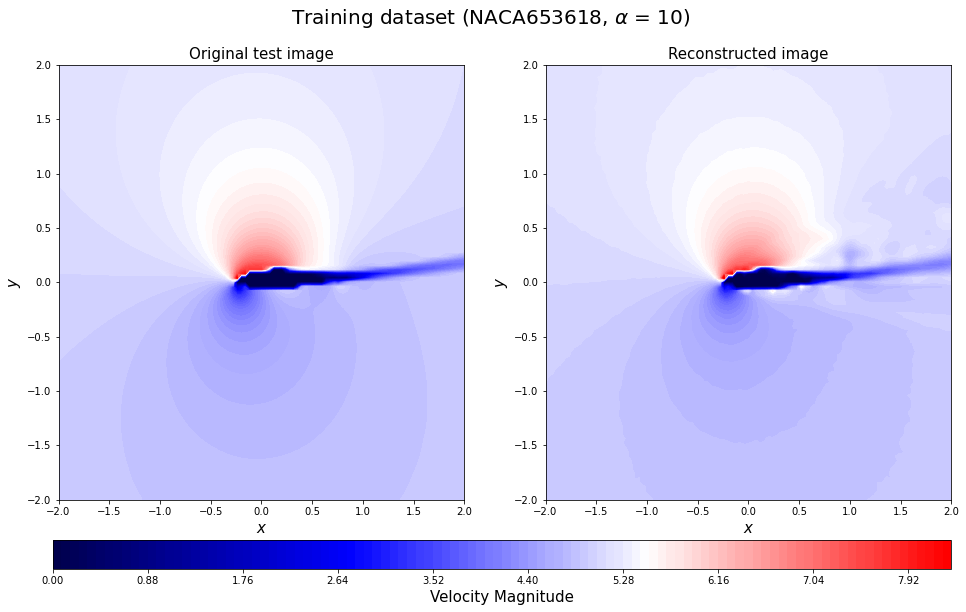

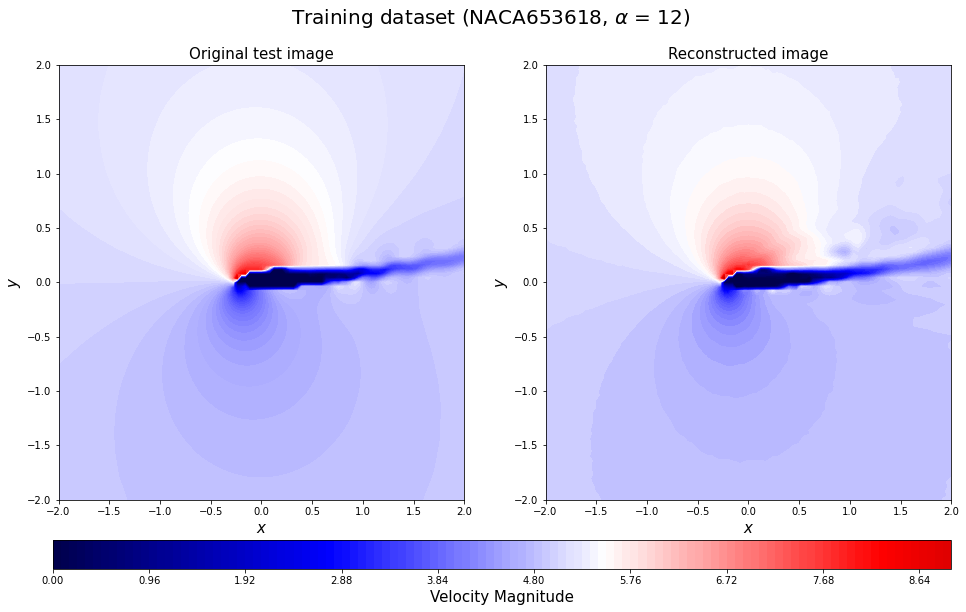

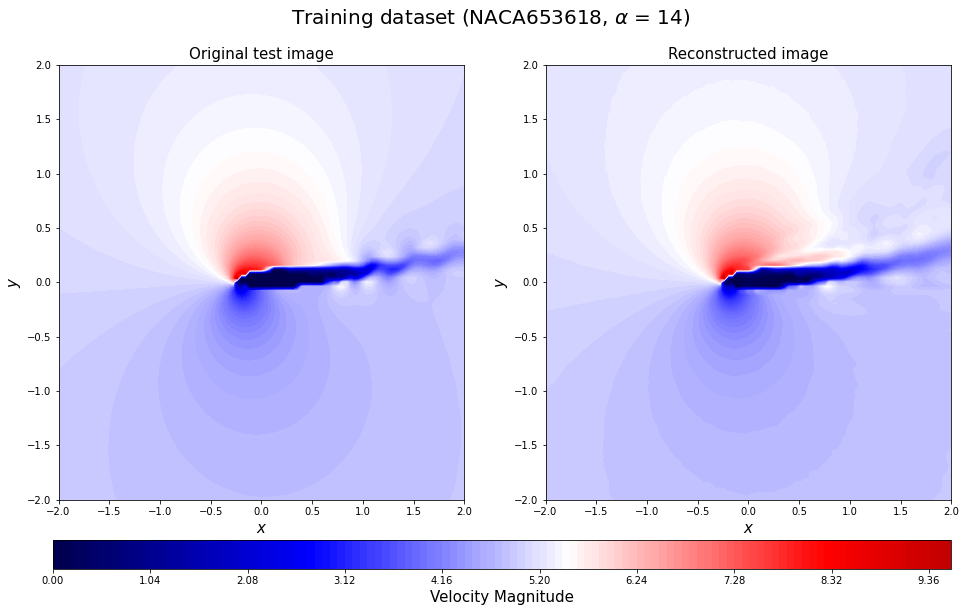

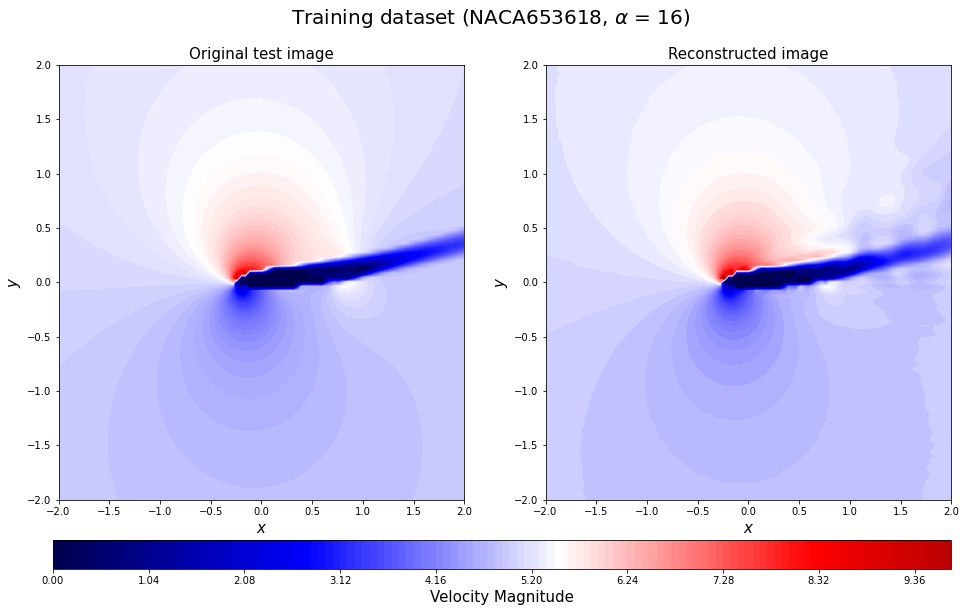

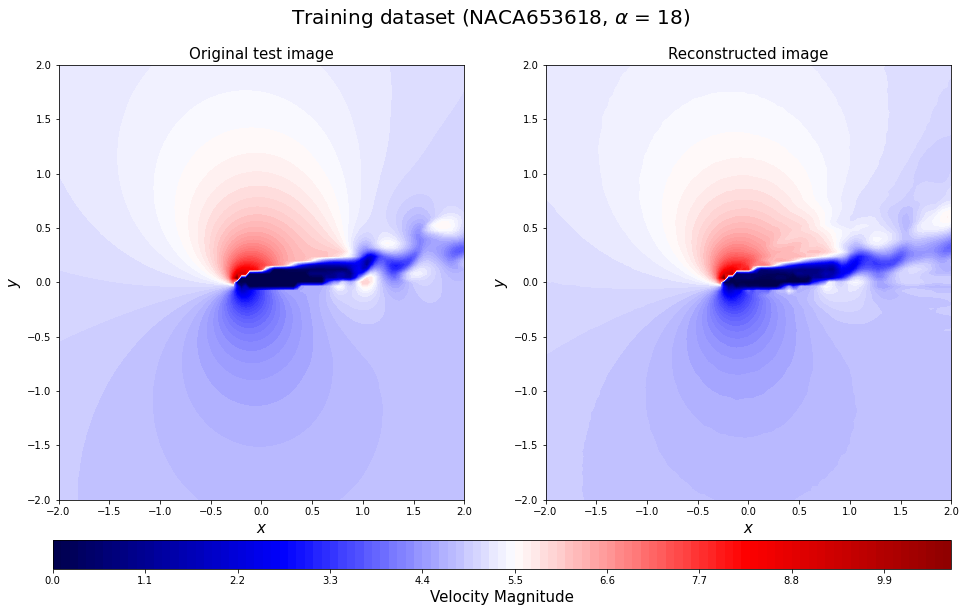

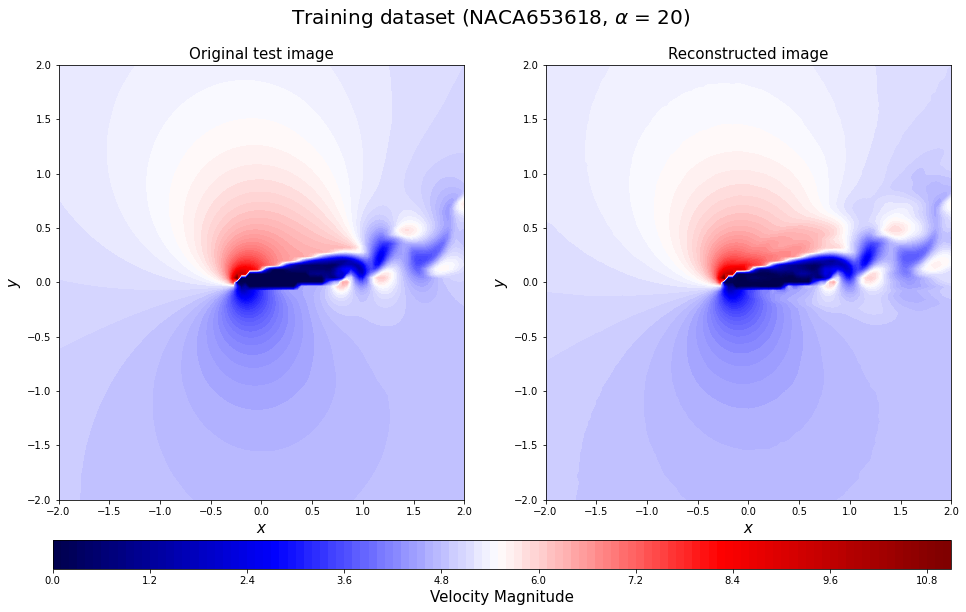

In [67]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train2[c])[3:-2], aa_train[c]),fontsize=20)
    plt.show()

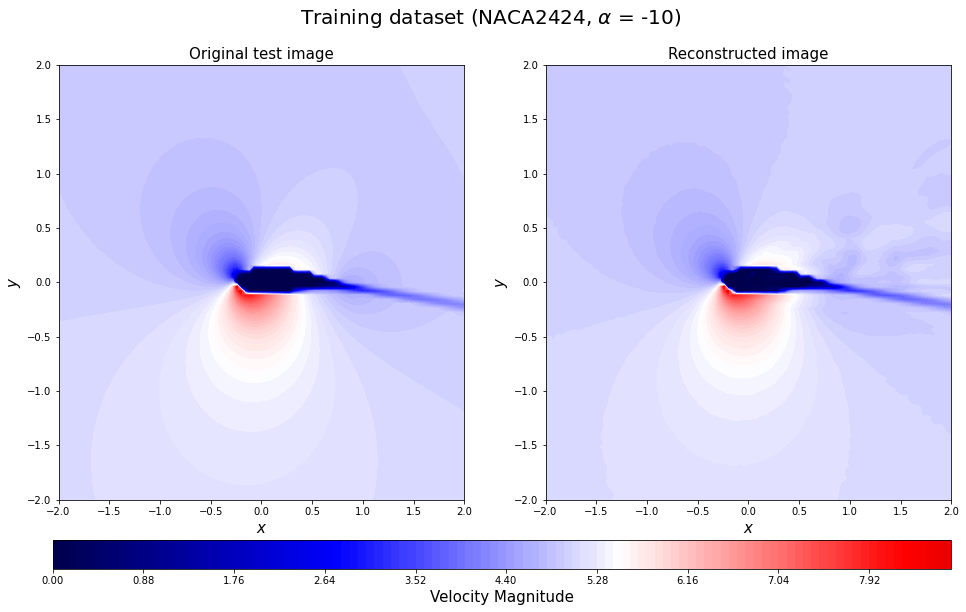

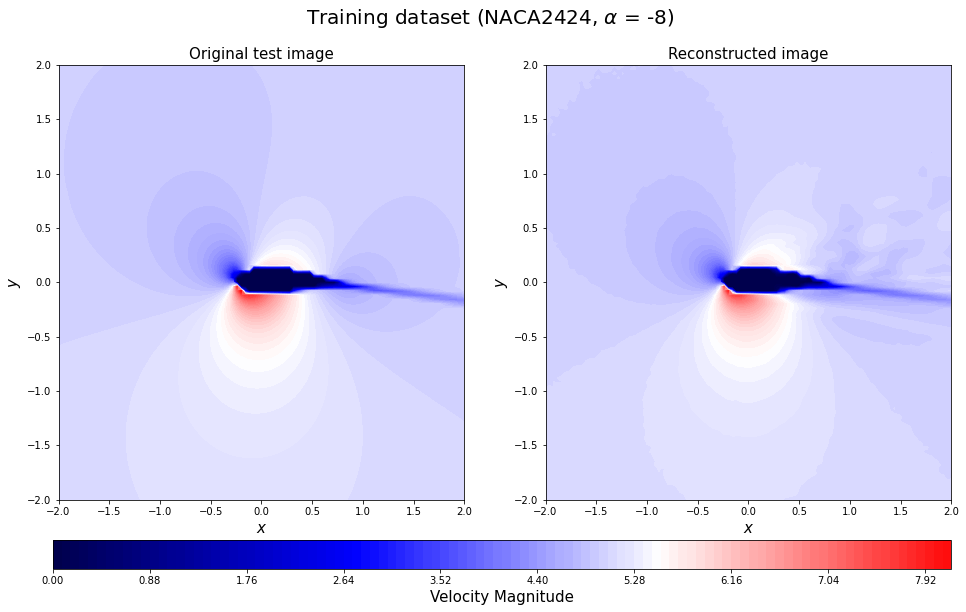

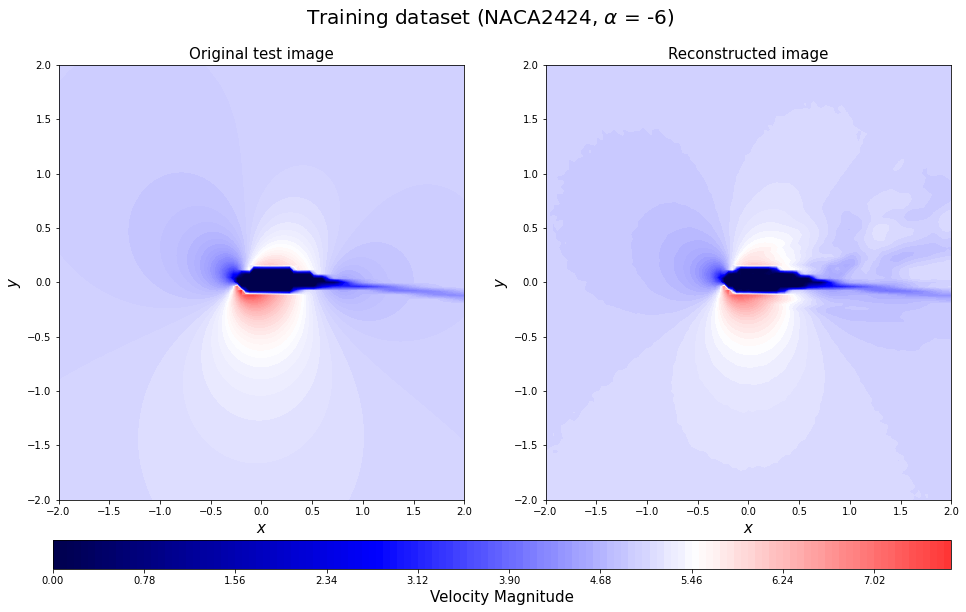

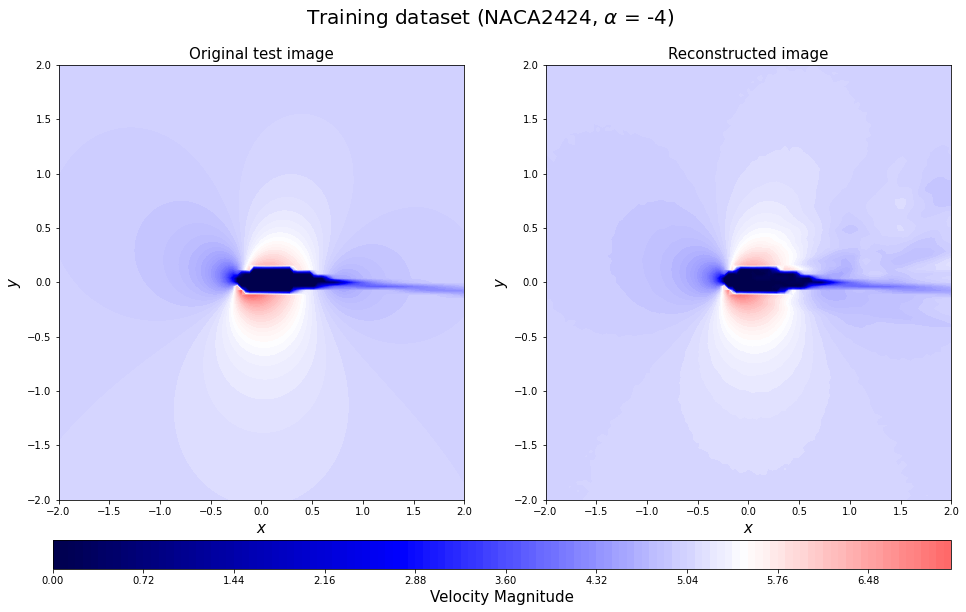

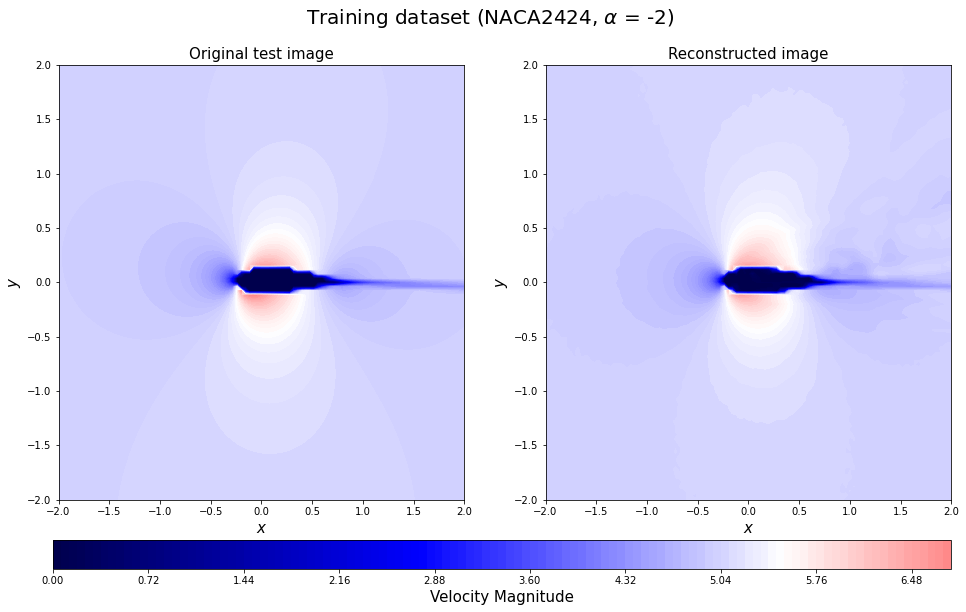

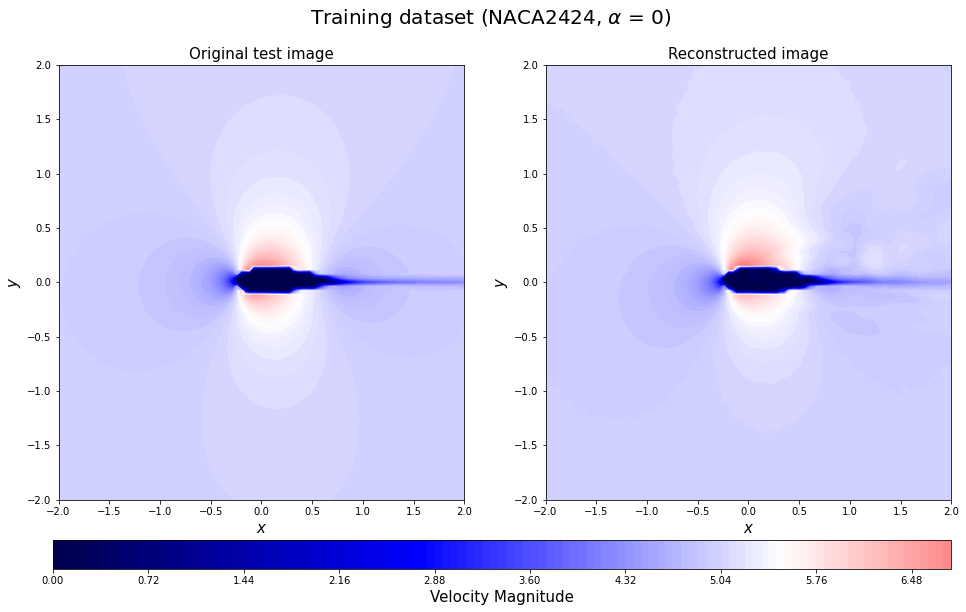

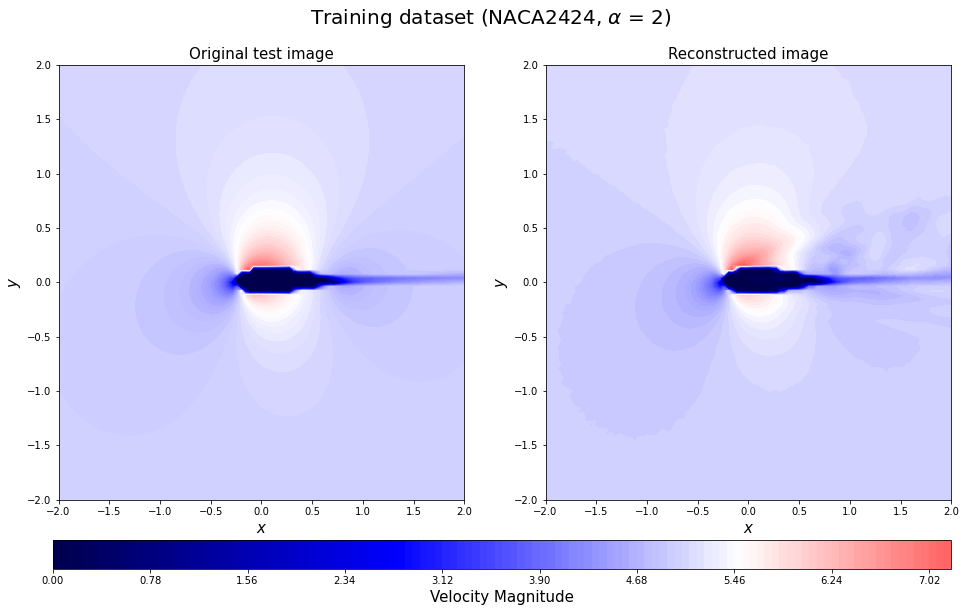

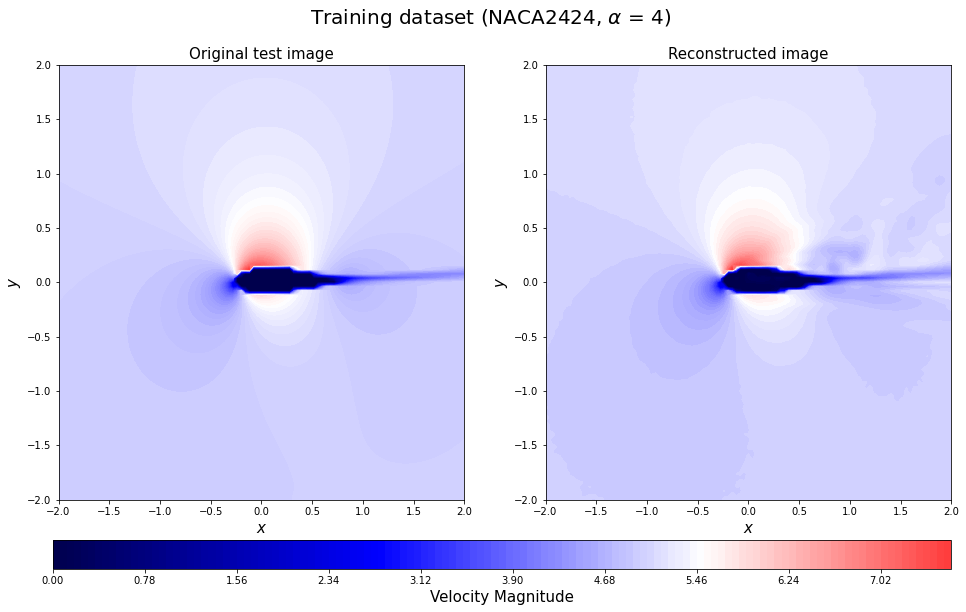

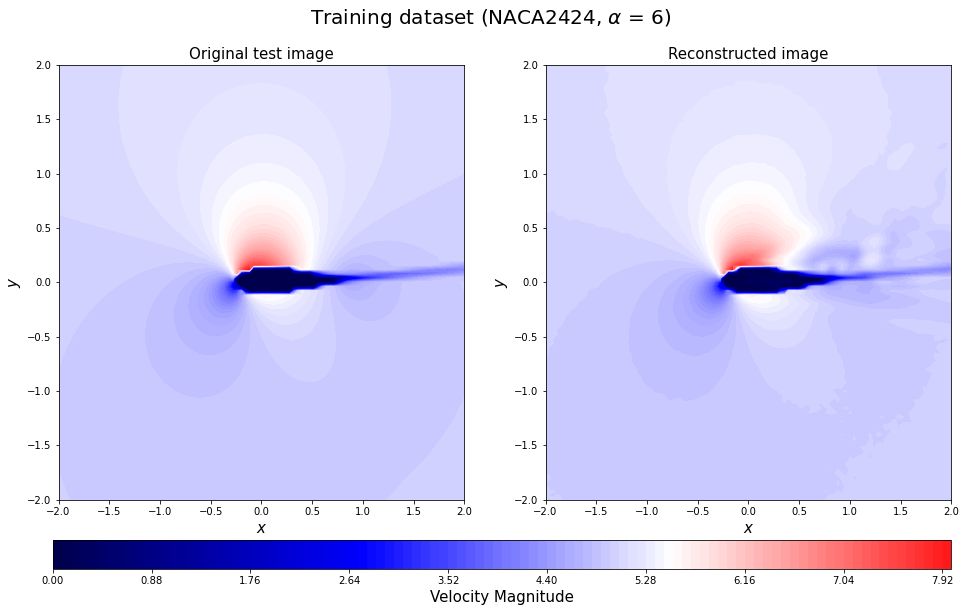

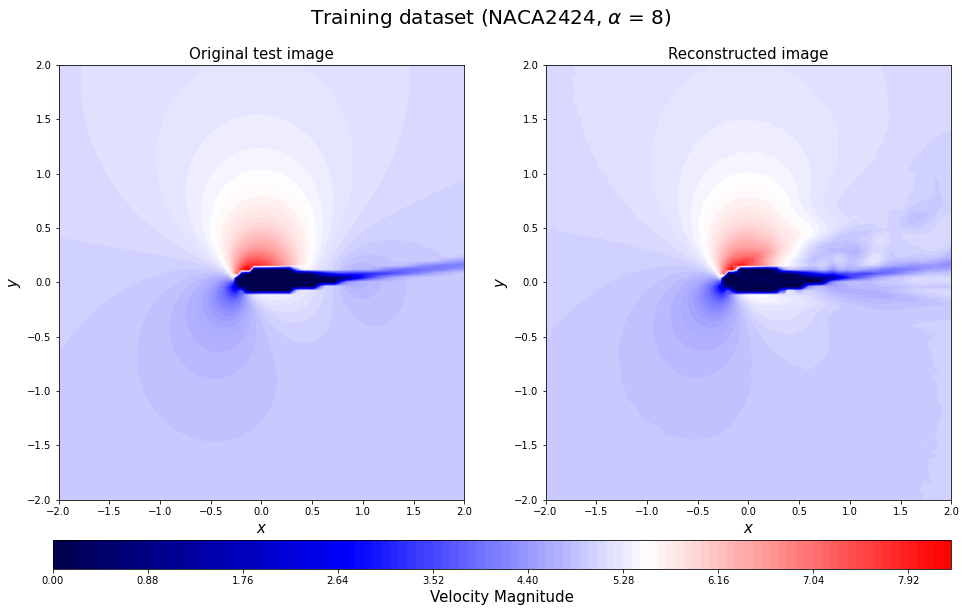

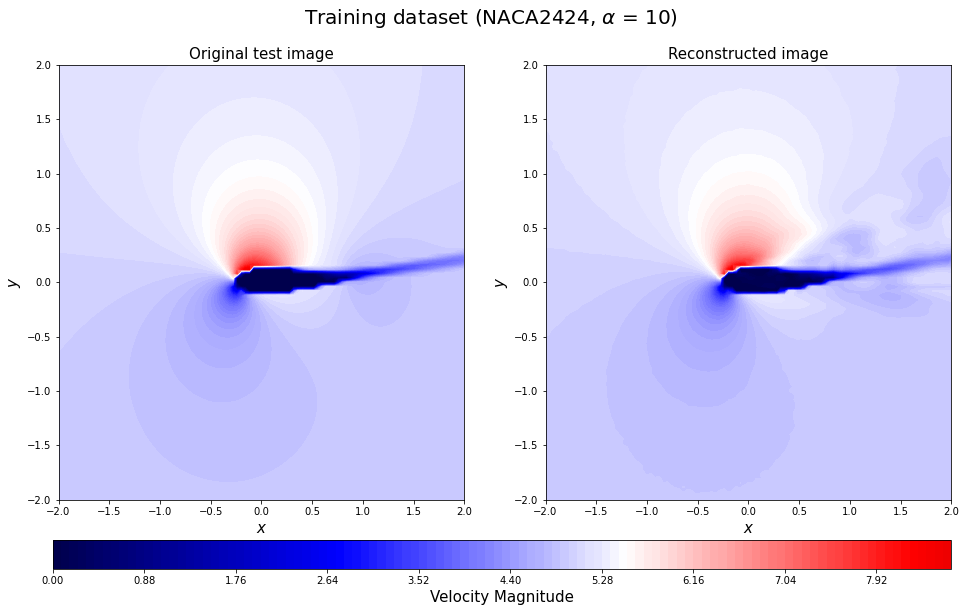

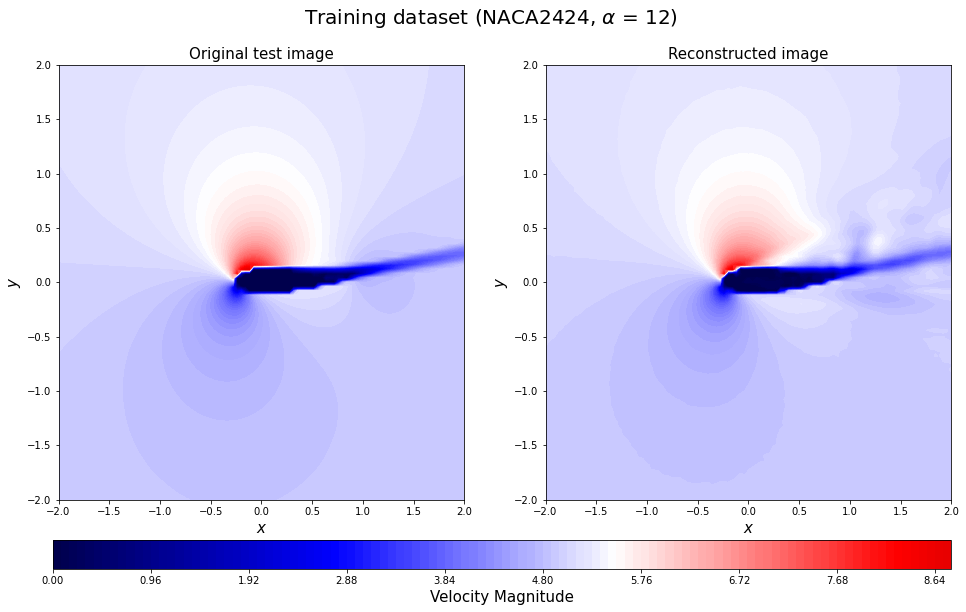

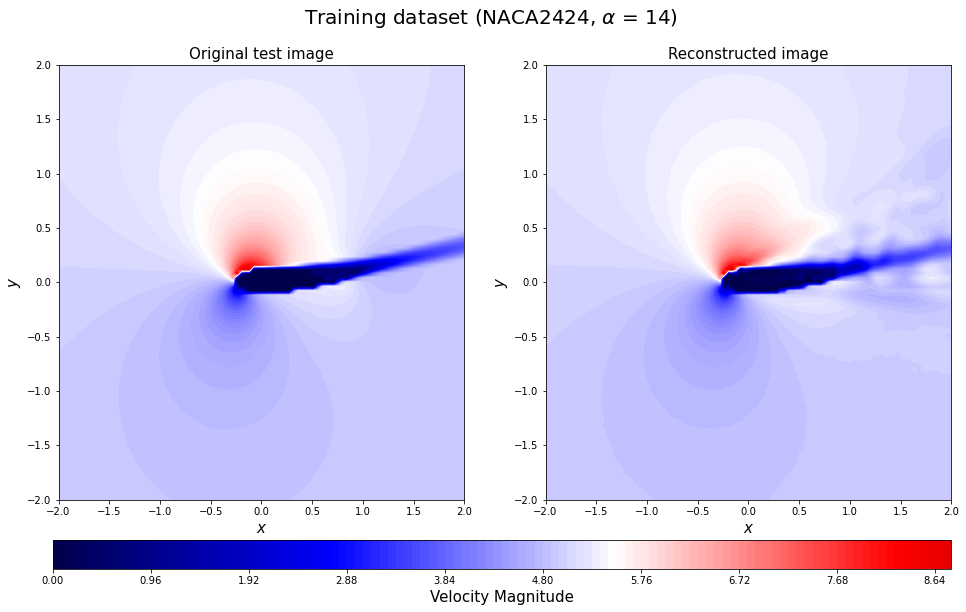

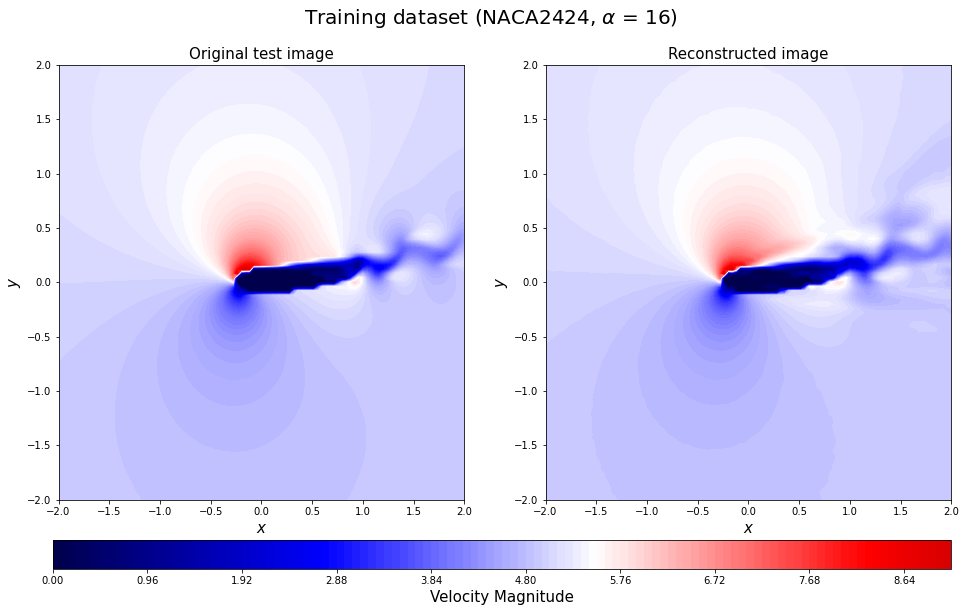

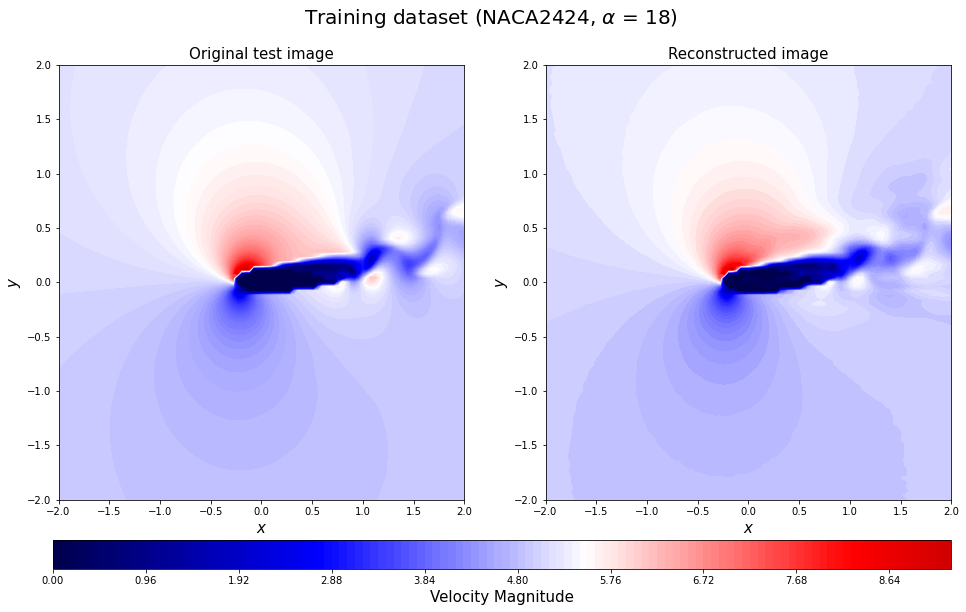

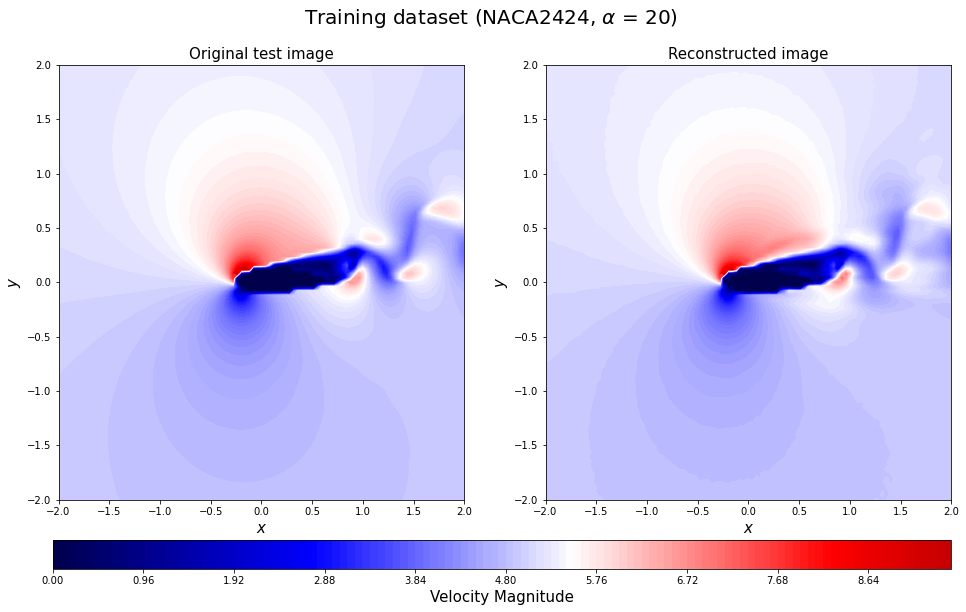

In [68]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train2[20*16+c])[3:-2], aa_train[20*16+c]),fontsize=20)
    plt.show()

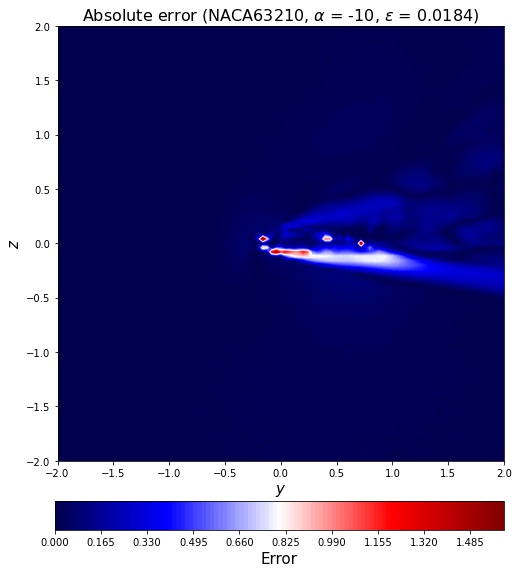

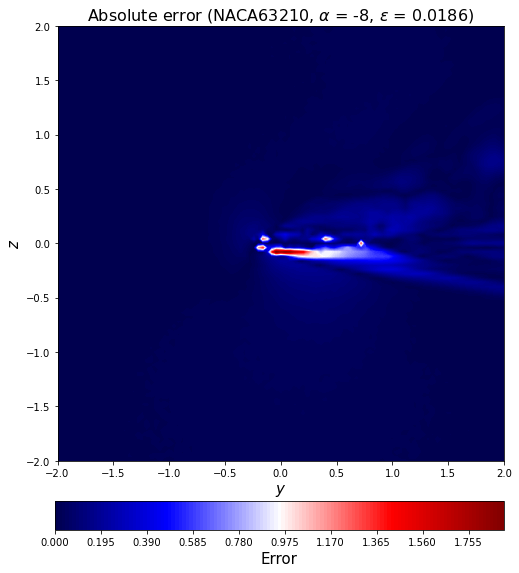

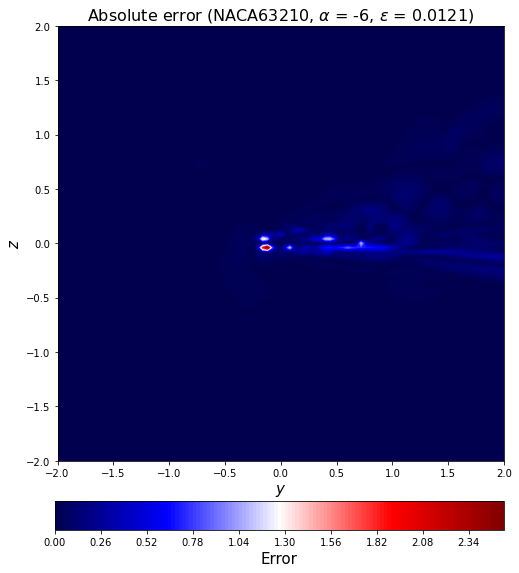

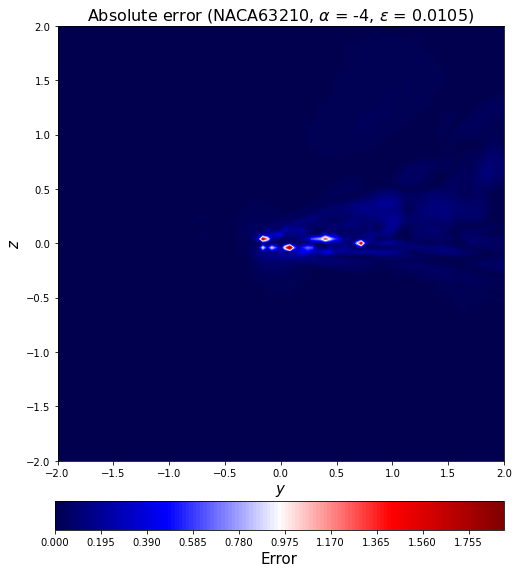

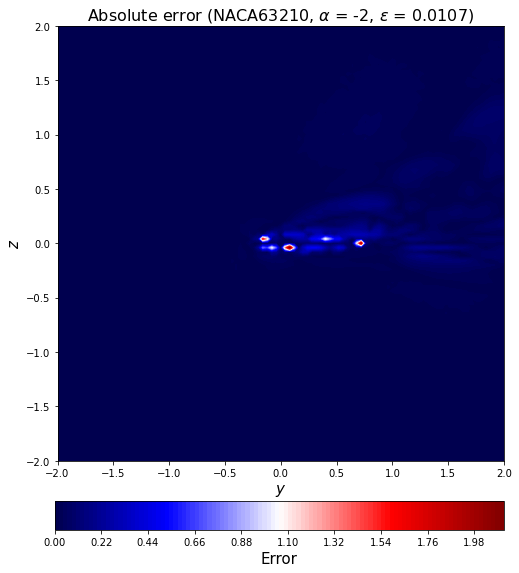

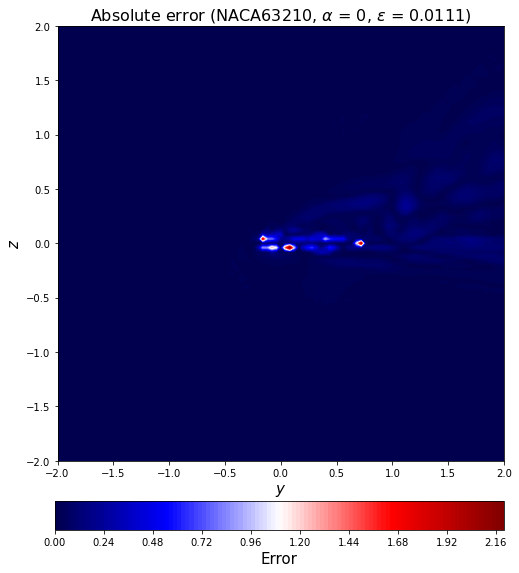

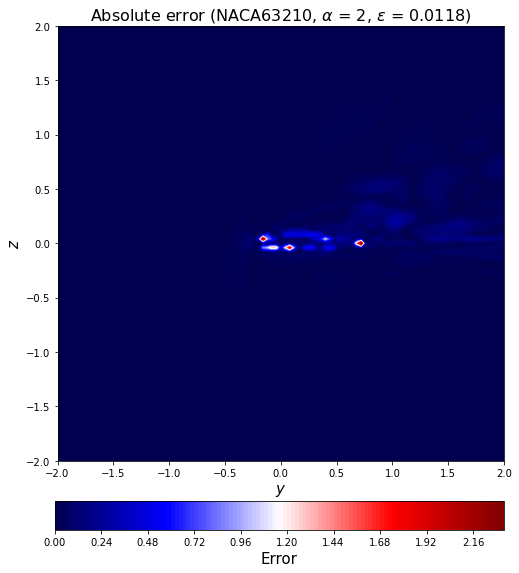

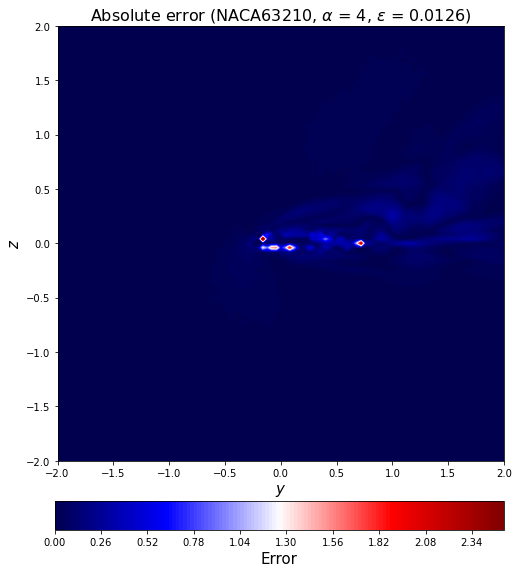

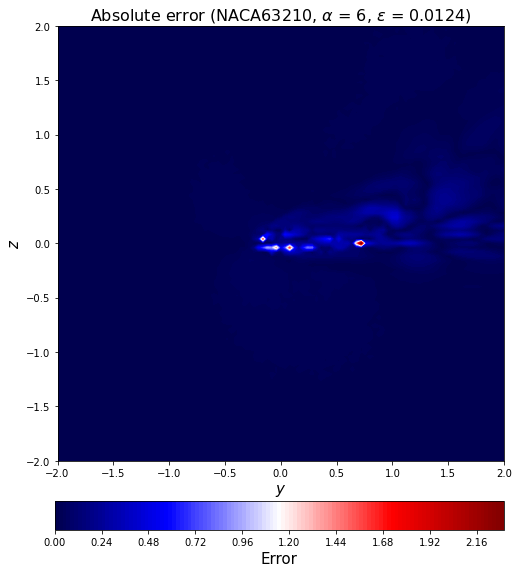

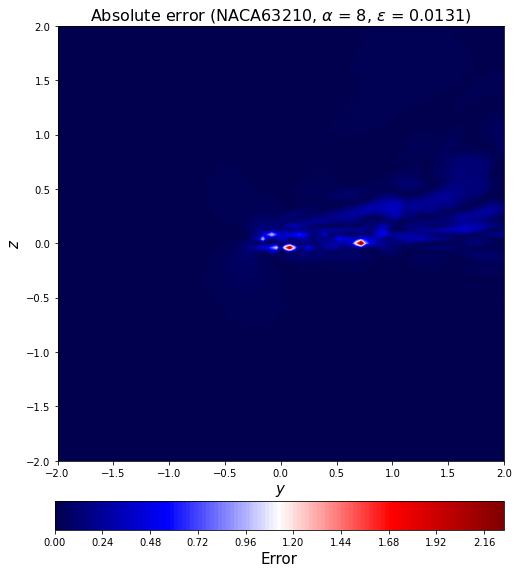

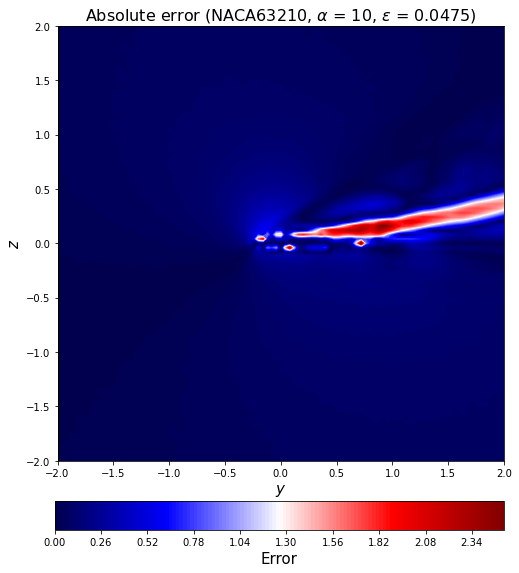

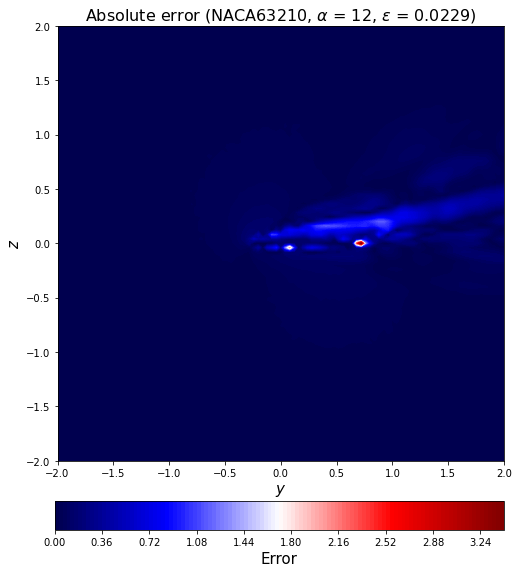

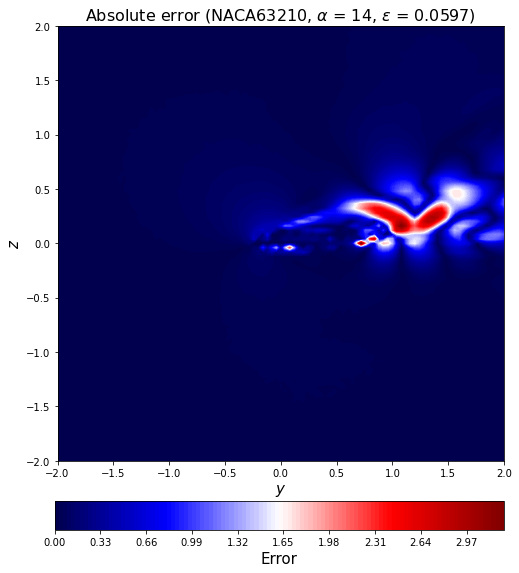

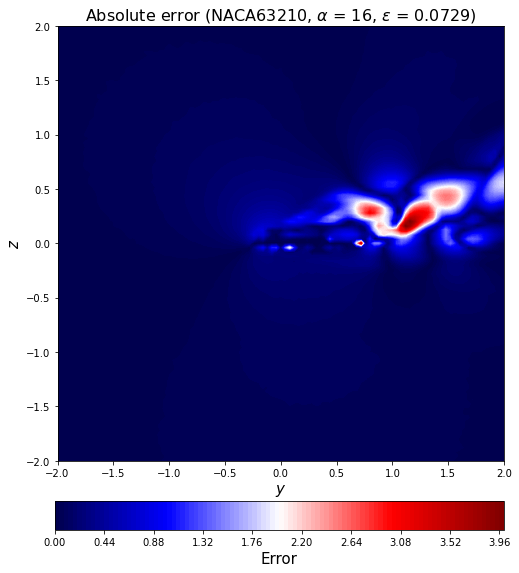

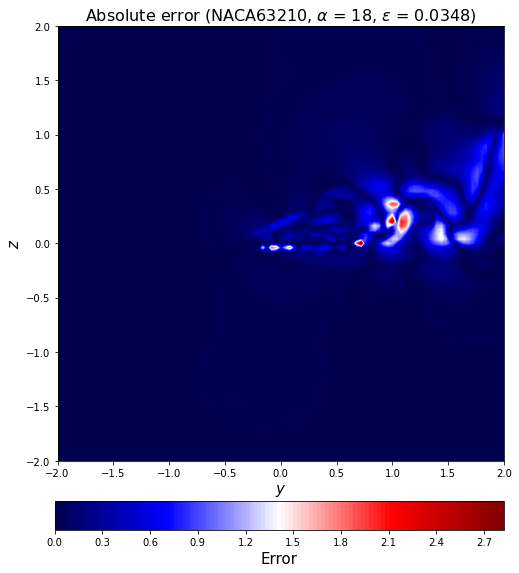

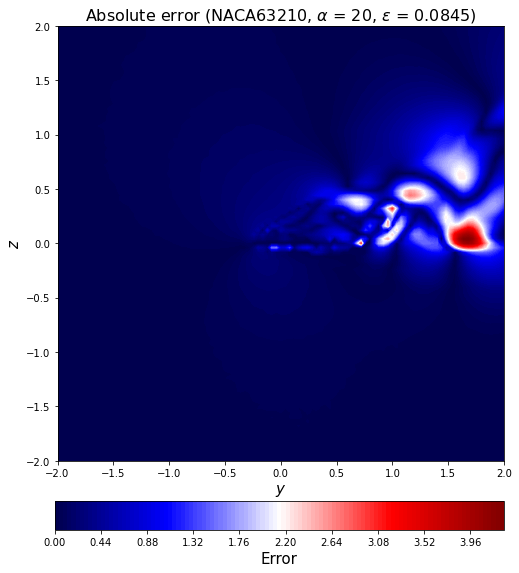

In [69]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[2*16+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test2[2*16+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*16+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

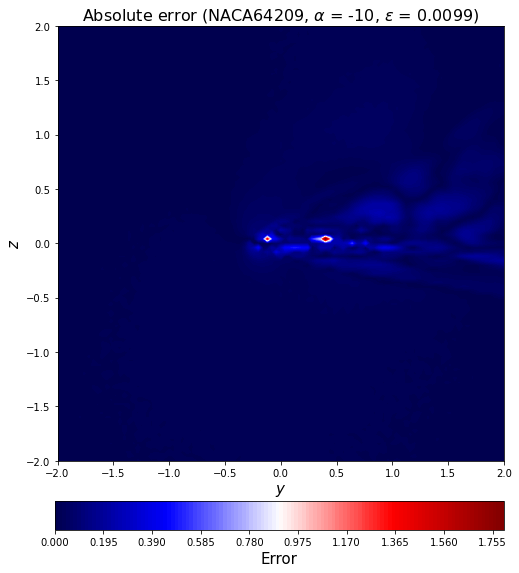

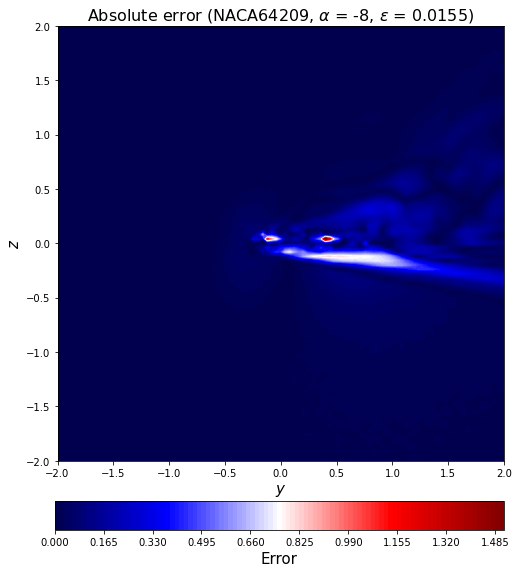

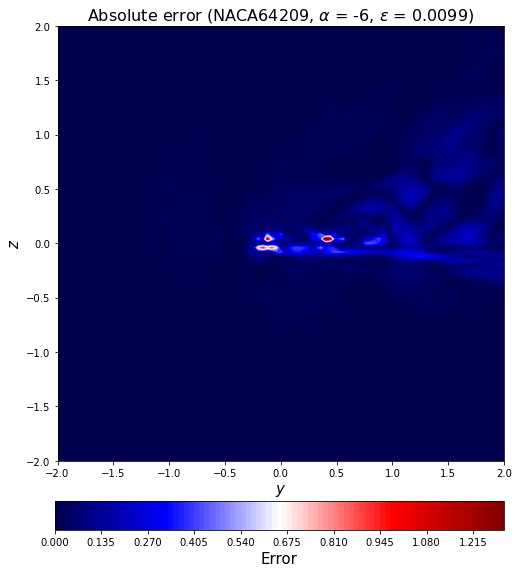

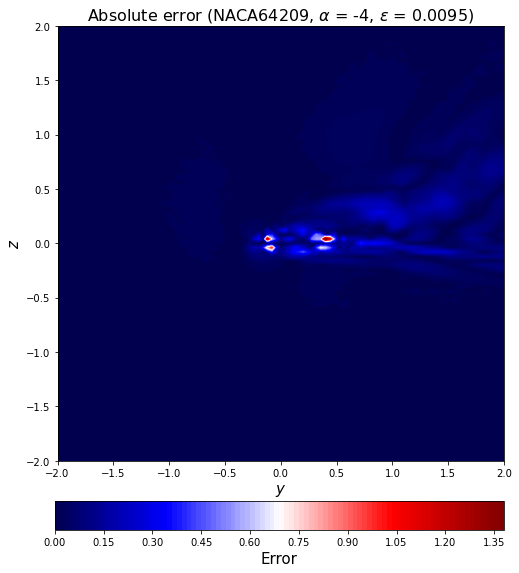

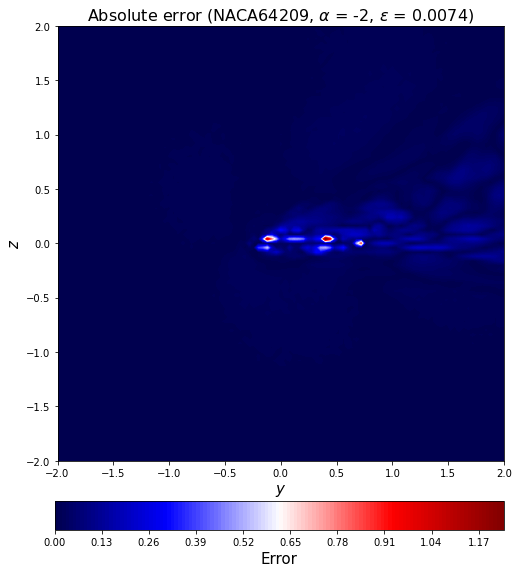

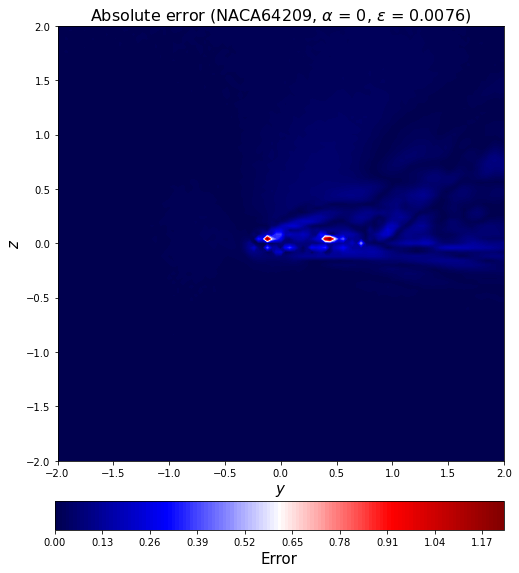

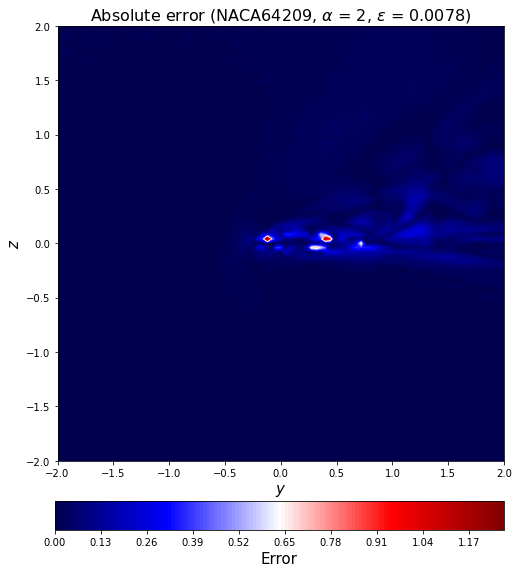

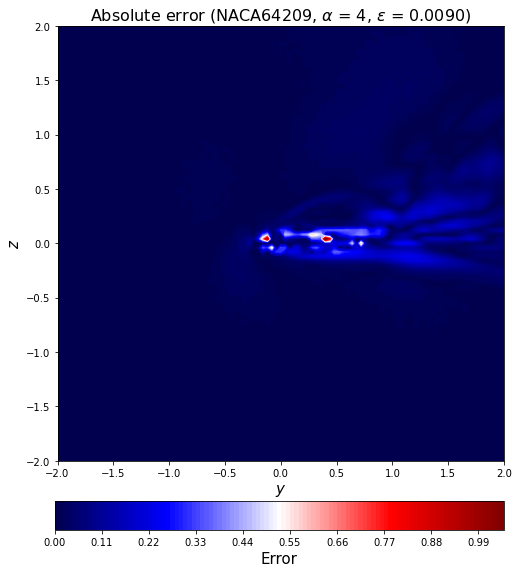

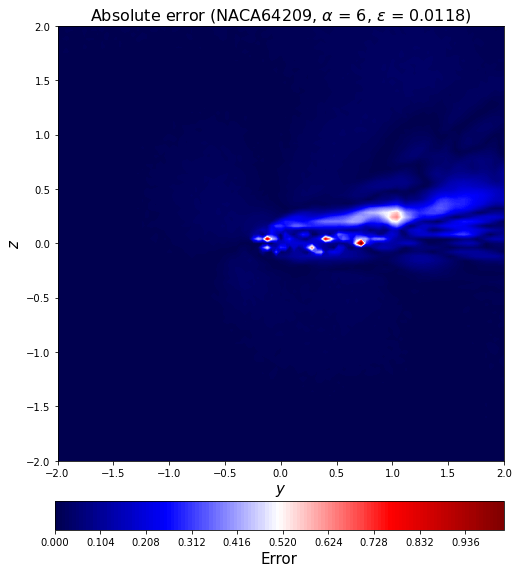

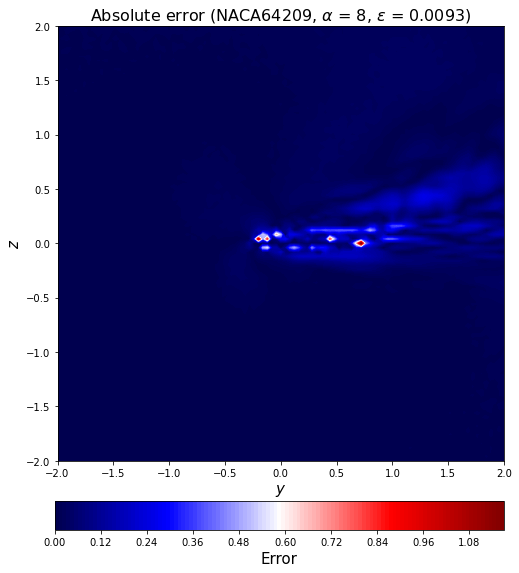

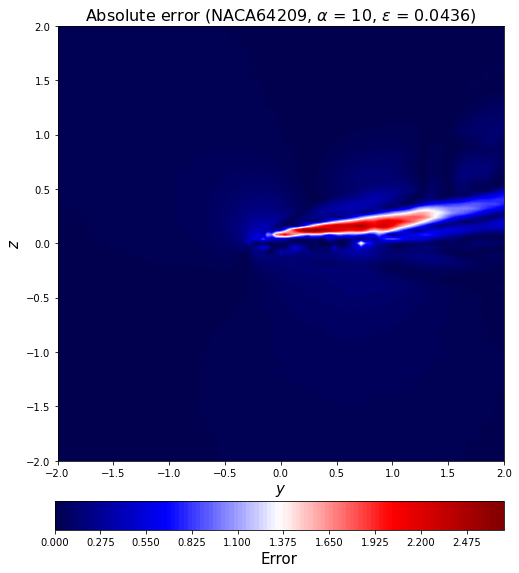

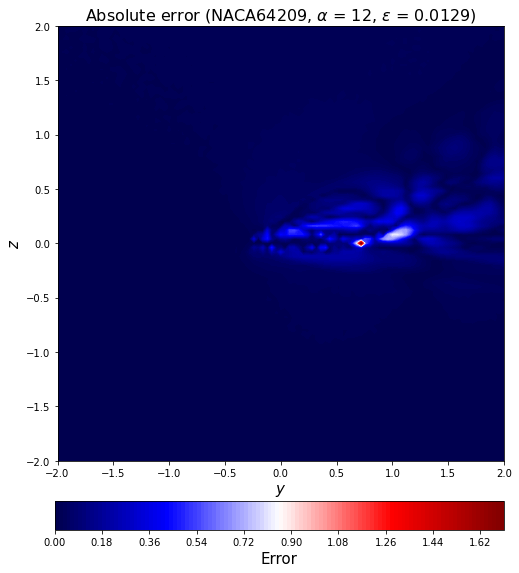

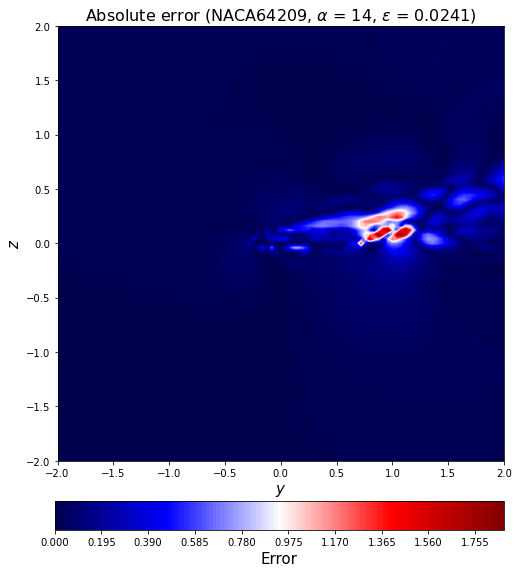

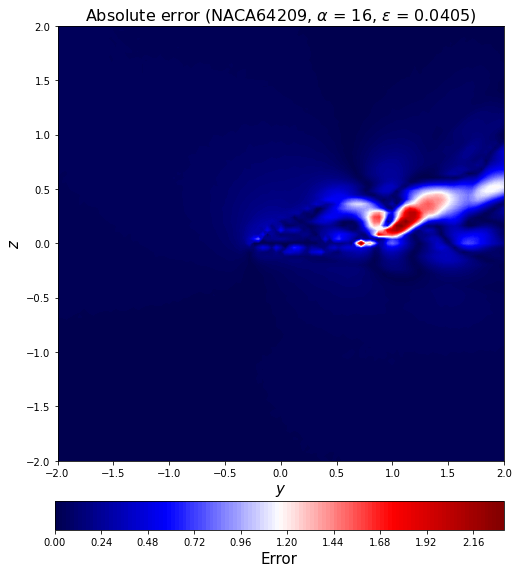

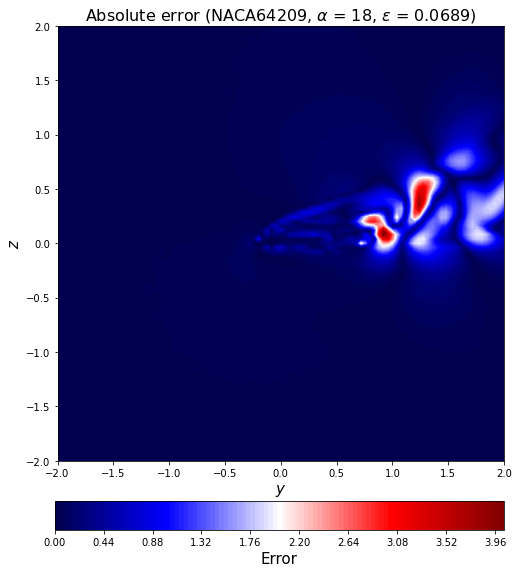

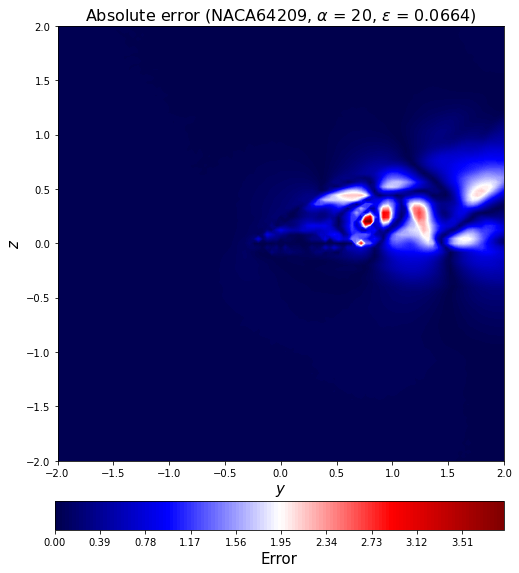

In [70]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test2[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

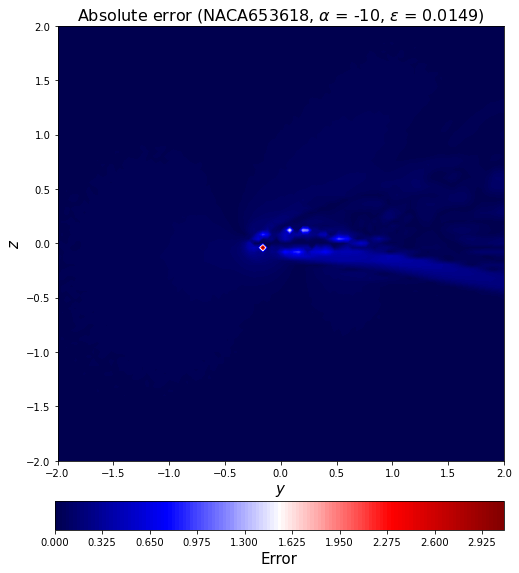

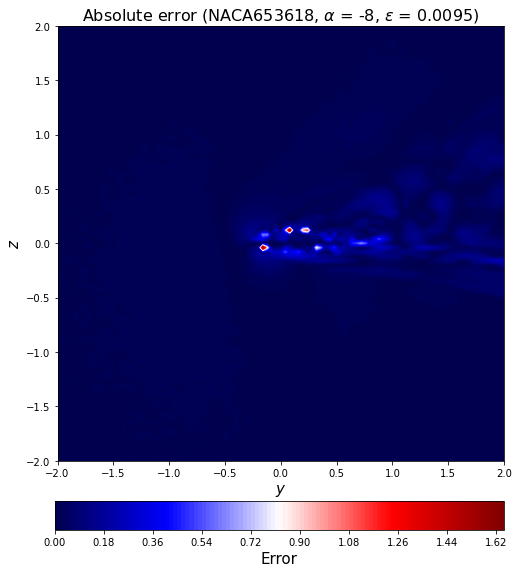

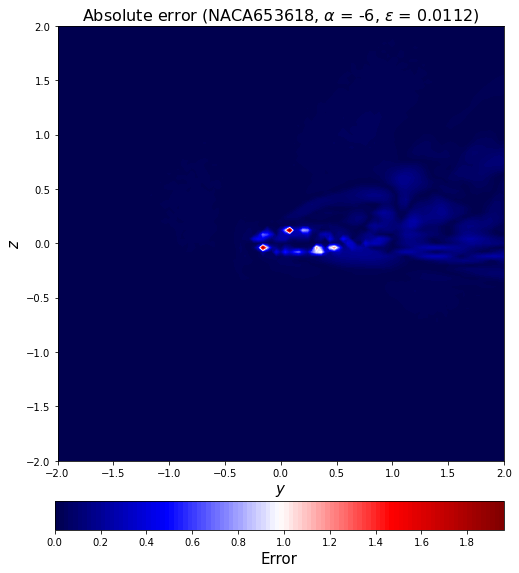

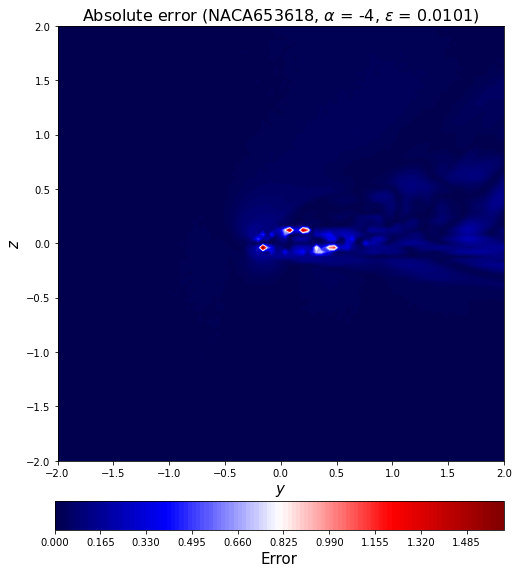

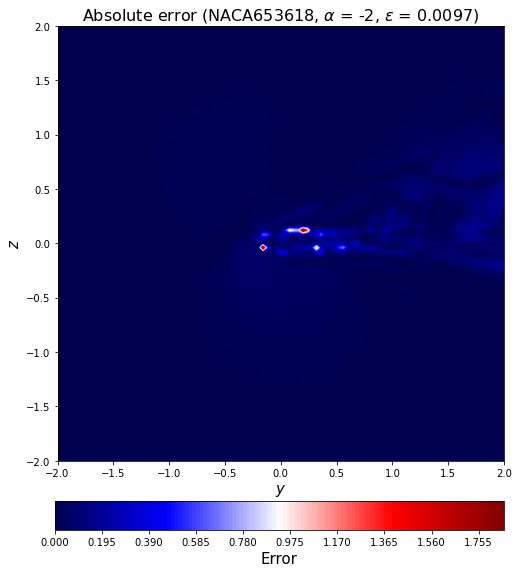

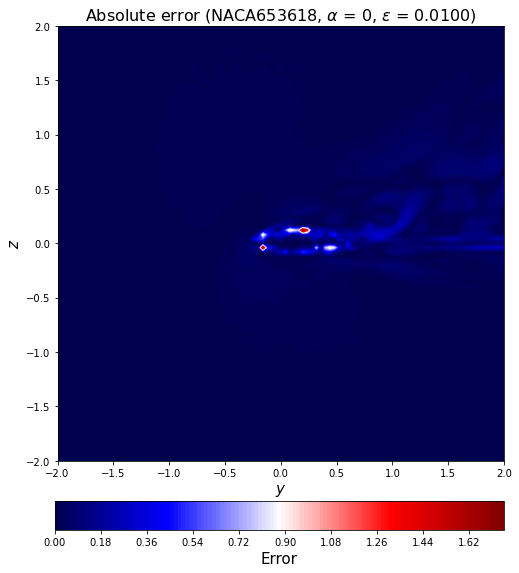

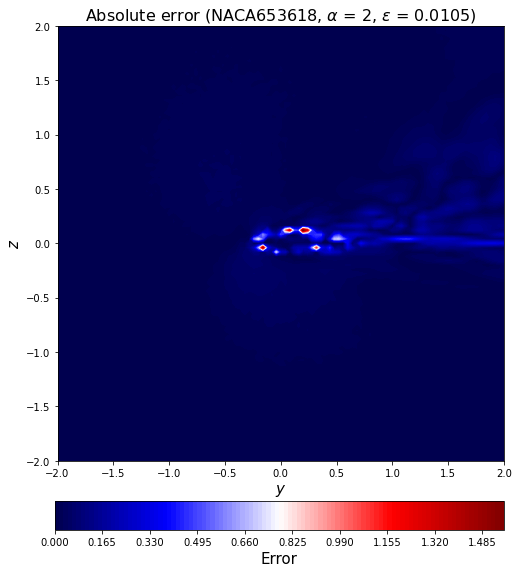

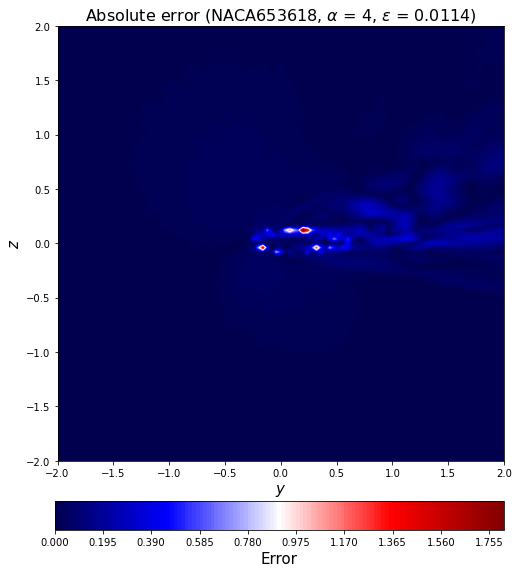

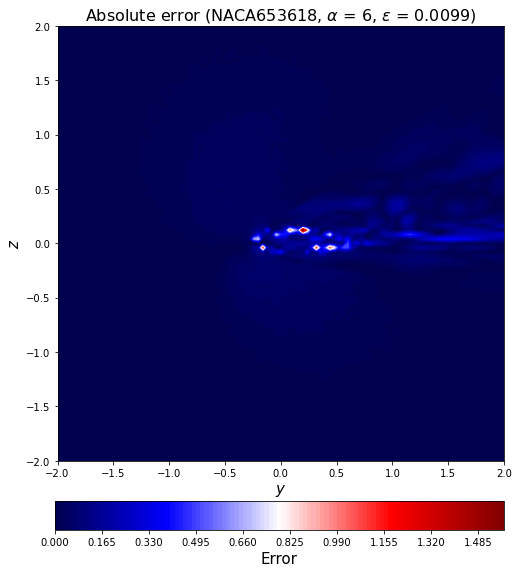

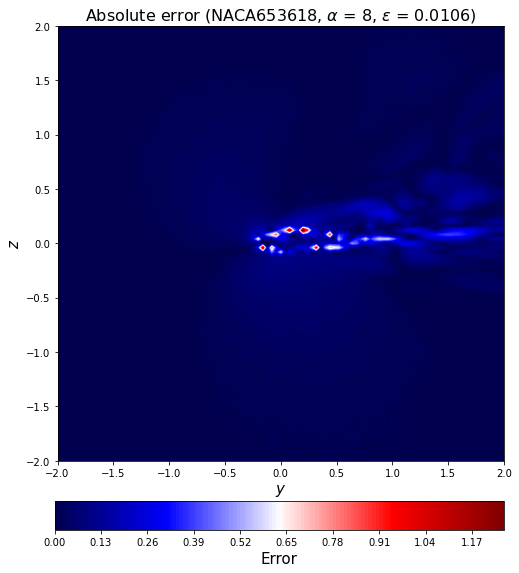

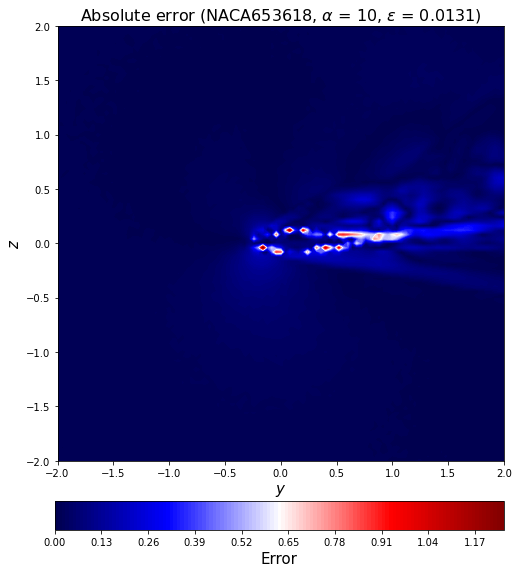

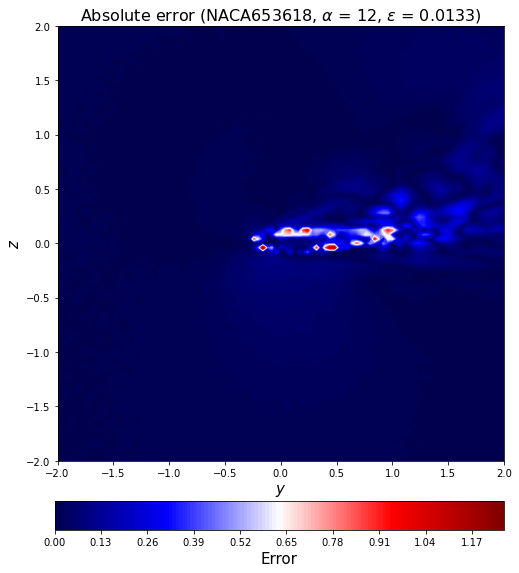

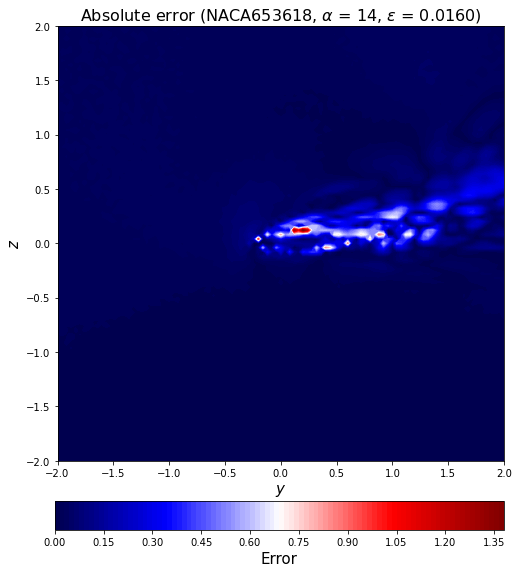

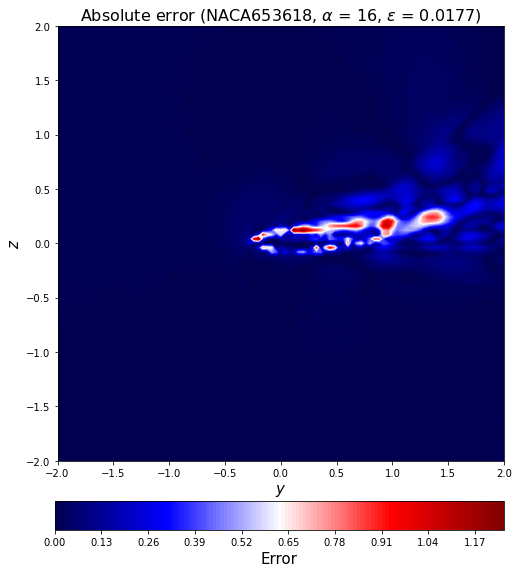

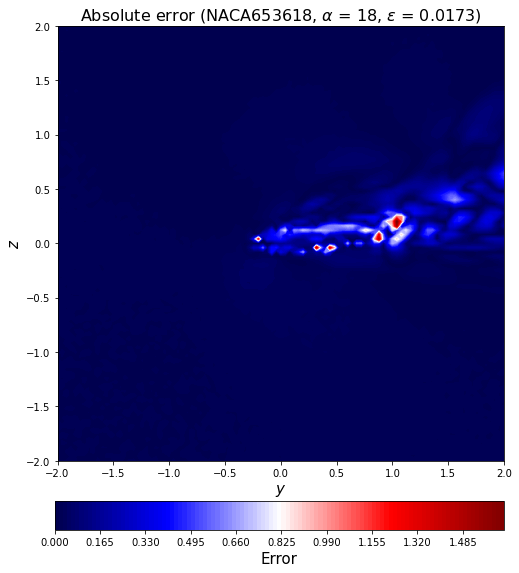

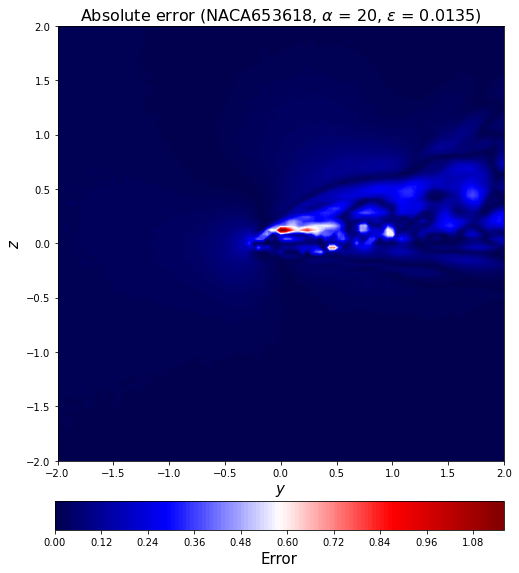

In [71]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train2[c])[3:-2],
                                                                       aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

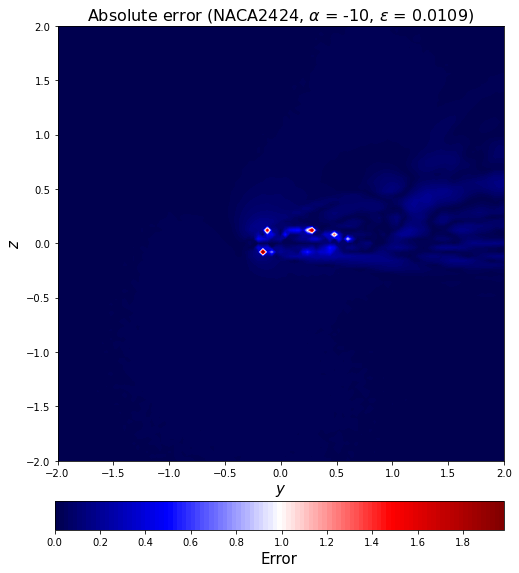

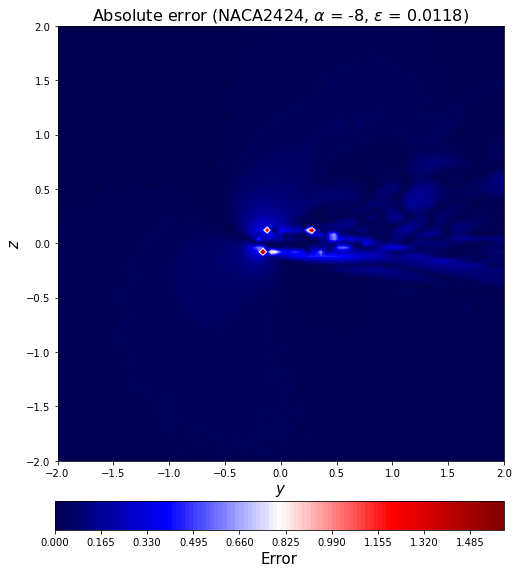

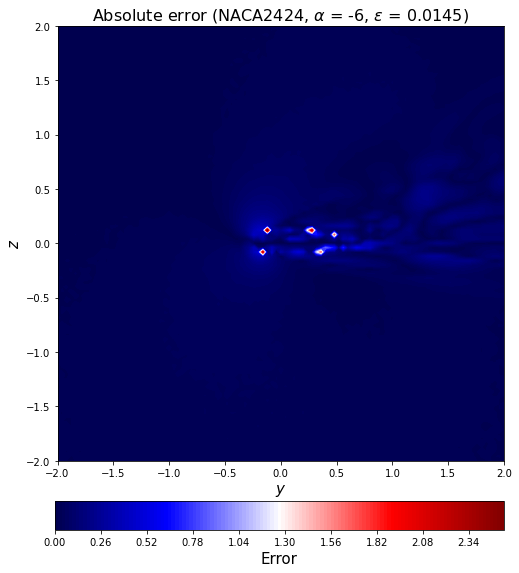

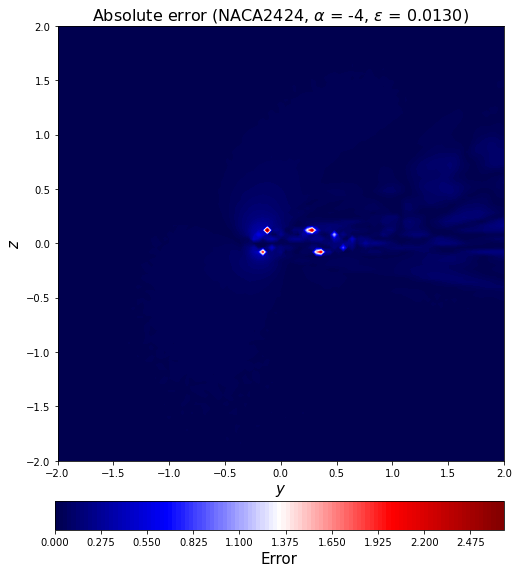

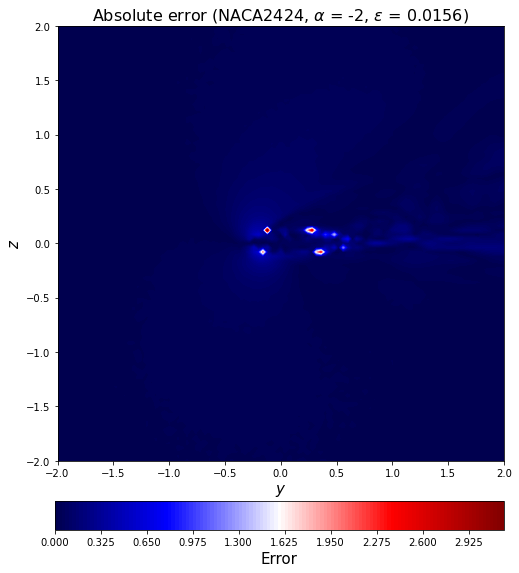

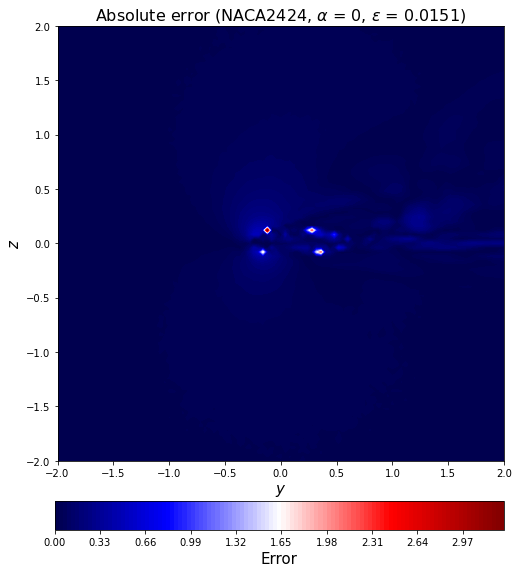

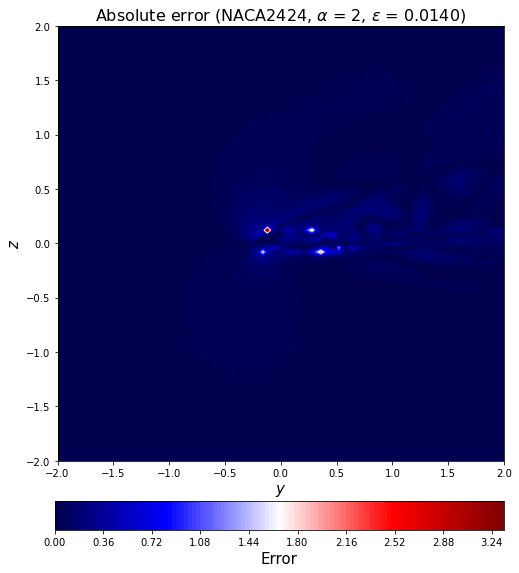

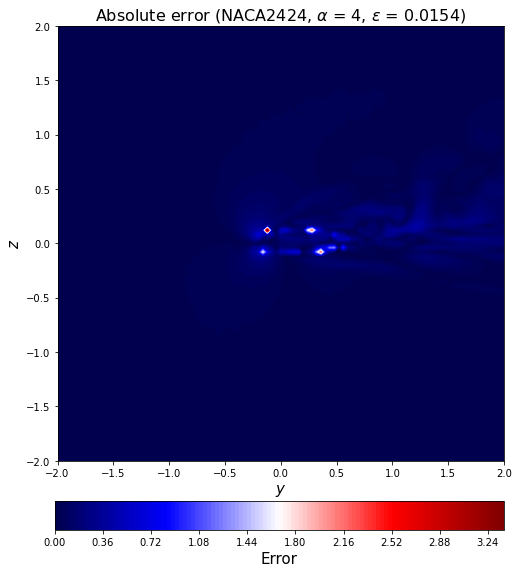

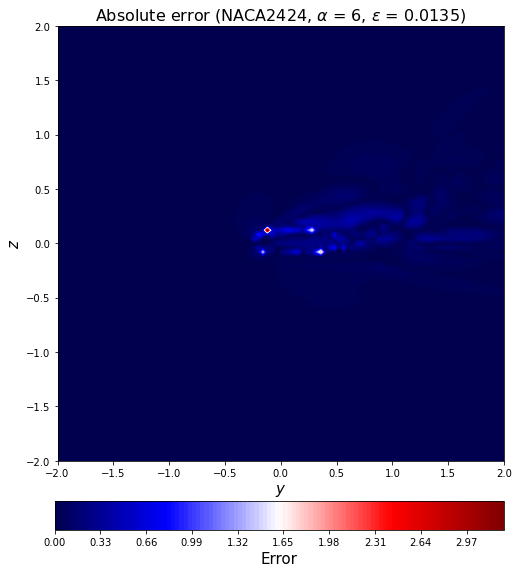

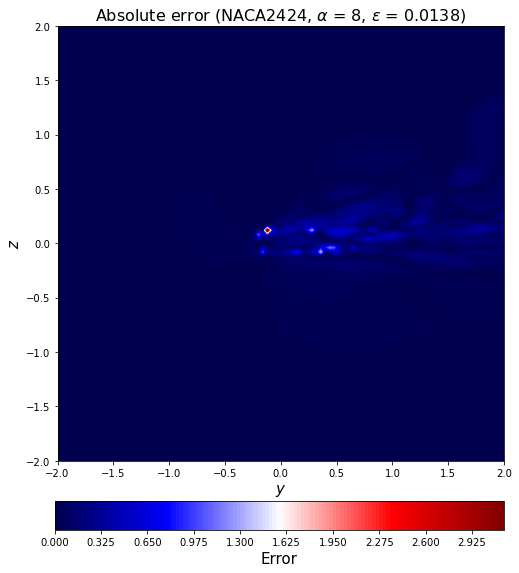

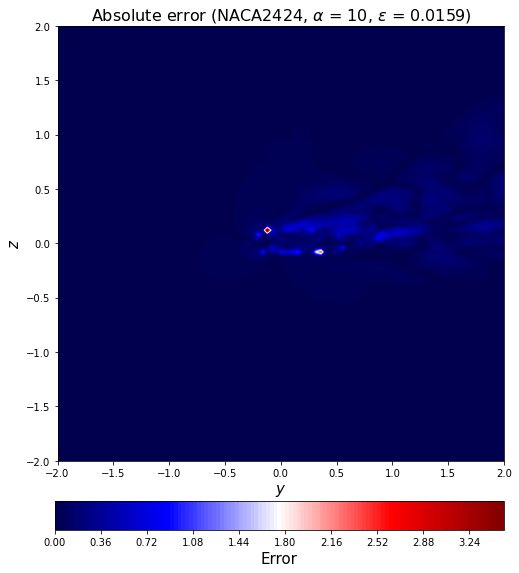

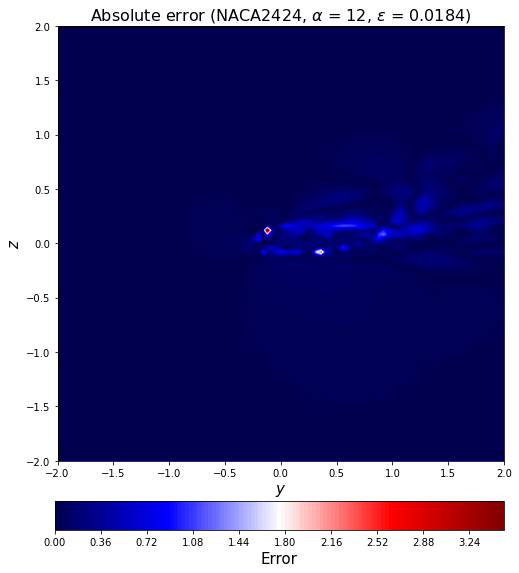

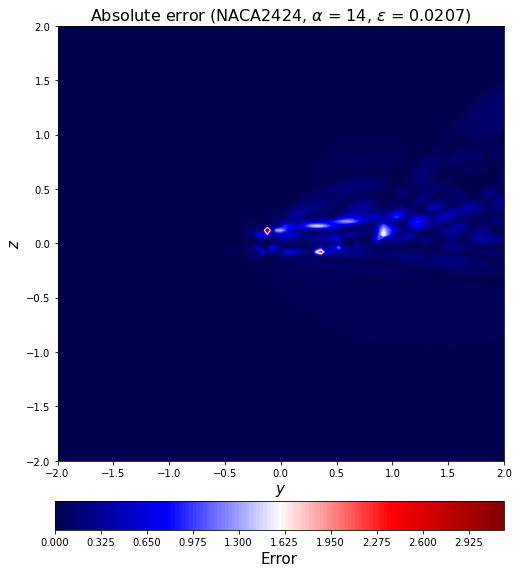

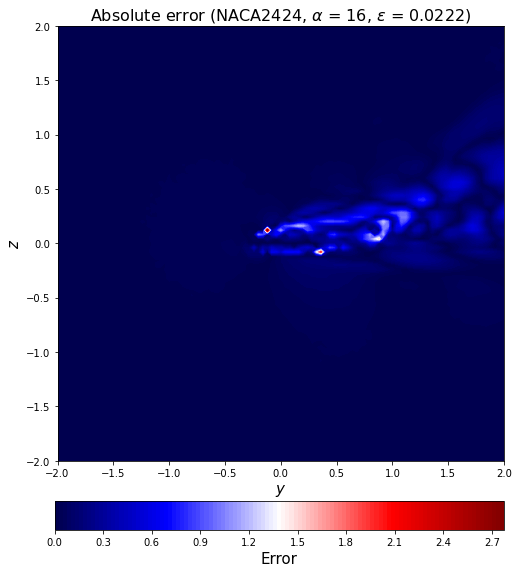

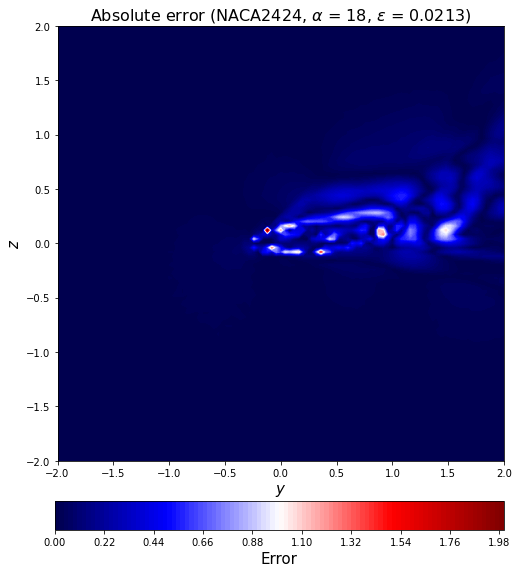

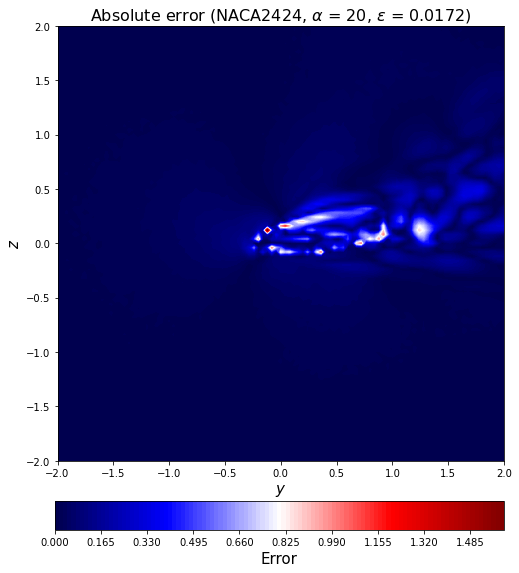

In [72]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[16*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train2[16*20+c])[3:-2],
                                                                       aa_train[16*20+c], l2_error_train_list[16*20+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()